# Optimal Design of Experiments for Clinical Trials using TrainSelPy

## A Comprehensive Tutorial for Clinical Researchers

### Table of Contents

1. [Introduction: Why Optimization Matters in Clinical Trials](#introduction)
2. [Setup and Installation](#setup)
3. [Part 1: Patient Selection for Maximum Information](#part1)
4. [Part 2: Multi-Center Trial Site Selection](#part2)
5. [Part 3: Dose-Finding Study Design](#part3)
6. [Part 4: Biomarker-Driven Patient Selection](#part4)
7. [Part 5: Multi-Objective Trial Design](#part5)
8. [Part 6: Adaptive Trial Design](#part6)
9. [Best Practices and Considerations](#best-practices)
10. [Conclusion and Further Resources](#conclusion)

## Introduction: Why Optimization Matters in Clinical Trials <a name="introduction"></a>

Clinical trials are expensive, time-consuming, and most importantly, involve human participants. Every decision we make - from which patients to enroll, to which sites to activate, to which doses to test - has profound implications for:

- **Statistical Power**: Our ability to detect true treatment effects
- **Patient Safety**: Minimizing exposure to ineffective or harmful doses
- **Resource Efficiency**: Making the best use of limited budgets and time
- **Generalizability**: Ensuring results apply to the broader patient population

Traditional approaches often rely on convenience sampling or simple randomization. However, **optimal design of experiments (DOE)** can help us make smarter choices by:

1. **Maximizing Information**: Getting the most statistical power from the fewest patients
2. **Balancing Competing Goals**: Such as diversity vs. homogeneity in patient populations
3. **Adapting to Constraints**: Working within budget, timeline, and ethical limitations

This tutorial will show you how to use TrainSelPy, a powerful optimization library, to design better clinical trials. We'll start with simple examples and build up to complex, real-world scenarios.

## Setup and Installation <a name="setup"></a>

First, let's set up our environment. We'll need TrainSelPy and some additional libraries for data manipulation and visualization.

In [1]:
# Install TrainSelPy if not already installed
# !pip install trainselpy numpy pandas matplotlib seaborn scikit-learn

# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict, Any, Tuple
import warnings
warnings.filterwarnings('ignore')

# Import TrainSelPy components
from trainselpy import (
    make_data,
    train_sel,
    train_sel_control,
    set_control_default,
    dopt,  # D-optimality criterion
)

# Set random seed for reproducibility
np.random.seed(42)

# Configure plotting
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

print("Setup complete! TrainSelPy is ready for clinical trial optimization.")

Setup complete! TrainSelPy is ready for clinical trial optimization.


## Part 1: Patient Selection for Maximum Information <a name="part1"></a>

### The Challenge

Imagine you're designing a Phase II clinical trial for a new diabetes medication. You have access to 500 potential participants with varying characteristics:
- Age
- Baseline HbA1c levels
- BMI
- Duration of diabetes
- Presence of complications

You can only enroll 100 patients due to budget constraints. **Which 100 patients should you select to maximize the information gained from your trial?**

This is where D-optimality comes in. It selects patients whose characteristics provide the most information for estimating treatment effects.

Patient Pool Summary:
              age  duration_years         bmi  baseline_hba1c  \
count  500.000000      500.000000  500.000000      500.000000   
mean    55.034204       15.043361   29.566314        8.607706   
std     11.602816        9.756830    4.989784        1.330580   
min     18.000000        0.000000   18.000000        6.500000   
25%     46.596311        7.202460   25.987852        7.582096   
50%     55.153566       14.951615   29.599029        8.486630   
75%     62.641399       22.928401   32.773692        9.549654   
max     85.000000       30.000000   42.008416       12.000000   

       has_complications  
count         500.000000  
mean            0.808000  
std             0.394268  
min             0.000000  
25%             1.000000  
50%             1.000000  
75%             1.000000  
max             1.000000  

Patients with complications: 404 (80.8%)


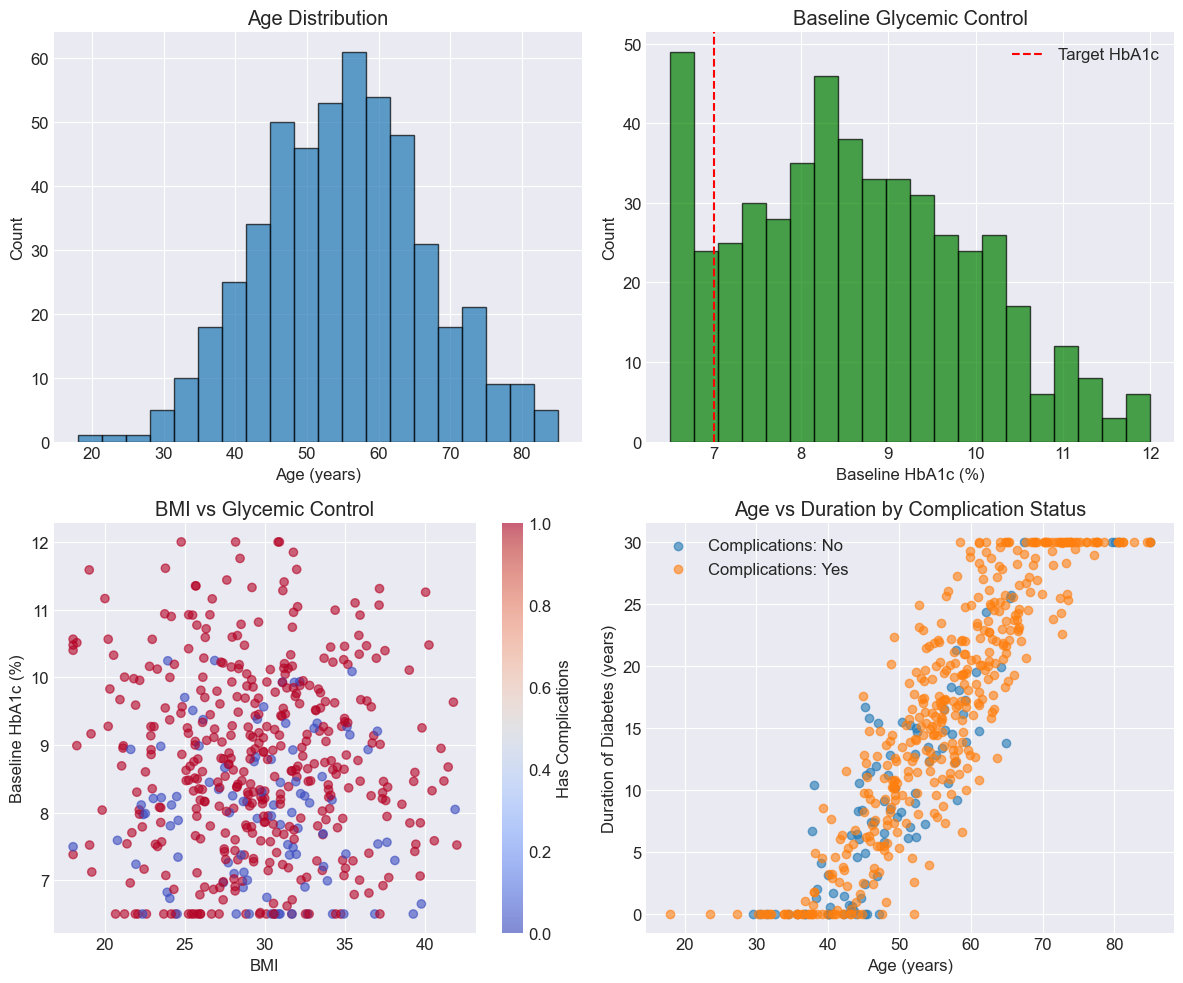

In [2]:
# Generate synthetic patient data
def generate_patient_data(n_patients=500):
    """
    Generate realistic patient data for a diabetes trial.
    This simulates the kind of baseline characteristics we might see.
    """
    # Create correlated patient characteristics
    age = np.random.normal(55, 12, n_patients)  # Age centered around 55
    age = np.clip(age, 18, 85)  # Ensure reasonable age range
    
    # Duration of diabetes correlates with age
    duration = np.maximum(0, age - 40 + np.random.normal(0, 5, n_patients))
    duration = np.clip(duration, 0, 30)
    
    # BMI - slightly higher in diabetes patients
    bmi = np.random.normal(29, 5, n_patients)
    bmi = np.clip(bmi, 18, 45)
    
    # HbA1c - baseline glycemic control
    # Higher values indicate worse control
    hba1c = np.random.normal(8.5, 1.5, n_patients)
    hba1c = np.clip(hba1c, 6.5, 12)
    
    # Complications (binary: 0 or 1)
    # Probability increases with duration and poor control
    complication_prob = 1 / (1 + np.exp(-0.1 * duration - 0.5 * (hba1c - 8)))
    complications = np.random.binomial(1, complication_prob)
    
    # Create patient DataFrame
    patients = pd.DataFrame({
        'patient_id': [f'P{i:04d}' for i in range(n_patients)],
        'age': age,
        'duration_years': duration,
        'bmi': bmi,
        'baseline_hba1c': hba1c,
        'has_complications': complications
    })
    
    return patients

# Generate our patient pool
patient_pool = generate_patient_data(500)

print("Patient Pool Summary:")
print(patient_pool.describe())
print(f"\nPatients with complications: {patient_pool['has_complications'].sum()} ({patient_pool['has_complications'].mean()*100:.1f}%)")

# Visualize patient characteristics
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Age distribution
axes[0, 0].hist(patient_pool['age'], bins=20, edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Age (years)')
axes[0, 0].set_ylabel('Count')
axes[0, 0].set_title('Age Distribution')

# HbA1c distribution
axes[0, 1].hist(patient_pool['baseline_hba1c'], bins=20, edgecolor='black', alpha=0.7, color='green')
axes[0, 1].set_xlabel('Baseline HbA1c (%)')
axes[0, 1].set_ylabel('Count')
axes[0, 1].set_title('Baseline Glycemic Control')
axes[0, 1].axvline(x=7, color='red', linestyle='--', label='Target HbA1c')
axes[0, 1].legend()

# BMI vs HbA1c scatter
scatter = axes[1, 0].scatter(patient_pool['bmi'], patient_pool['baseline_hba1c'], 
                            c=patient_pool['has_complications'], cmap='coolwarm', alpha=0.6)
axes[1, 0].set_xlabel('BMI')
axes[1, 0].set_ylabel('Baseline HbA1c (%)')
axes[1, 0].set_title('BMI vs Glycemic Control')
plt.colorbar(scatter, ax=axes[1, 0], label='Has Complications')

# Duration vs Age with complications
for comp in [0, 1]:
    mask = patient_pool['has_complications'] == comp
    axes[1, 1].scatter(patient_pool.loc[mask, 'age'], 
                      patient_pool.loc[mask, 'duration_years'],
                      label=f'Complications: {"Yes" if comp else "No"}',
                      alpha=0.6)
axes[1, 1].set_xlabel('Age (years)')
axes[1, 1].set_ylabel('Duration of Diabetes (years)')
axes[1, 1].set_title('Age vs Duration by Complication Status')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

### Preparing Data for Optimization

Now we need to prepare our patient data for TrainSelPy. We'll create a design matrix that includes all the factors we want to consider in our selection. This is crucial because the optimization will select patients to maximize the information content of this design matrix.

In [3]:
# Create design matrix for optimization
def create_design_matrix(patients_df):
    """
    Create a design matrix that captures patient characteristics
    and their potential interactions with treatment.
    
    This matrix determines what information we're trying to maximize.
    """
    # Start with basic characteristics (standardized for numerical stability)
    from sklearn.preprocessing import StandardScaler
    
    # Select features for the design matrix
    features = ['age', 'duration_years', 'bmi', 'baseline_hba1c', 'has_complications']
    X = patients_df[features].copy()
    
    # Standardize continuous variables
    scaler = StandardScaler()
    continuous_features = ['age', 'duration_years', 'bmi', 'baseline_hba1c']
    X[continuous_features] = scaler.fit_transform(X[continuous_features])
    
    # Add intercept term (important for proper design matrix)
    X.insert(0, 'intercept', 1)
    
    # Add some interaction terms that might be clinically relevant
    X['age_x_duration'] = X['age'] * X['duration_years']
    X['hba1c_x_complications'] = X['baseline_hba1c'] * X['has_complications']
    
    return X.values, scaler

# Create the design matrix
design_matrix, scaler = create_design_matrix(patient_pool)
print(f"Design matrix shape: {design_matrix.shape}")
print(f"Number of patients: {design_matrix.shape[0]}")
print(f"Number of design factors (including interactions): {design_matrix.shape[1]}")

# Prepare data for TrainSelPy
ts_data = make_data(M=design_matrix)
ts_data["FeatureMat"] = design_matrix  # Required for D-optimality

Design matrix shape: (500, 8)
Number of patients: 500
Number of design factors (including interactions): 8


### Running the Optimization

Now comes the exciting part! We'll use TrainSelPy to select the optimal 100 patients from our pool of 500. The D-optimality criterion will ensure we get maximum statistical information from our selection.

In [4]:
# Set up optimization parameters
n_total_patients = len(patient_pool)
n_select = 100  # Number of patients to select for the trial

# Configure the genetic algorithm
control = train_sel_control(
    niterations=100,      # Number of generations
    npop=200,            # Population size
    nelite=50,           # Elite solutions to keep
    mutprob=0.05,        # Mutation probability
    crossprob=0.8,       # Crossover probability
    progress=True        # Show progress
)

print(f"Selecting {n_select} patients from {n_total_patients} candidates...")
print("This may take a moment as the algorithm searches for the optimal selection.\n")

# Run the optimization
result = train_sel(
    data=ts_data,
    candidates=[list(range(n_total_patients))],  # All patients are candidates
    setsizes=[n_select],                        # Select 100 patients
    settypes=["UOS"],                          # Unordered set (order doesn't matter)
    stat=dopt,                                  # Use D-optimality criterion
    control=control,
    verbose=True
)

# Extract selected patients
selected_indices = result.selected_indices[0]
selected_patients = patient_pool.iloc[selected_indices].copy()
not_selected_patients = patient_pool.drop(patient_pool.index[selected_indices])

print(f"\nOptimization complete!")
print(f"Final D-optimality value: {result.fitness:.6f}")
print(f"Number of patients selected: {len(selected_indices)}")

Selecting 100 patients from 500 candidates...
This may take a moment as the algorithm searches for the optimal selection.

Starting TrainSelPy optimization
Starting GA with population size 200
Initial best fitness: 32.131983930622276
Generation 0: Best fitness = 32.36251099347072
Generation 10: Best fitness = 33.19483163539658
Generation 20: Best fitness = 33.53055243477093
Generation 30: Best fitness = 33.581740640347526
Generation 40: Best fitness = 33.981520382932956
Generation 50: Best fitness = 34.09101384501594
Generation 60: Best fitness = 34.15742857823864
Generation 70: Best fitness = 34.18738329488233
Generation 80: Best fitness = 34.18738329488233
Generation 90: Best fitness = 34.18738329488233
Optimization completed in 12.30 seconds
Final fitness: 34.20309344100385

Optimization complete!
Final D-optimality value: 34.203093
Number of patients selected: 100


### Analyzing the Selection

Let's examine how the optimal selection differs from random selection. This will help us understand what the algorithm is doing and why it's valuable.

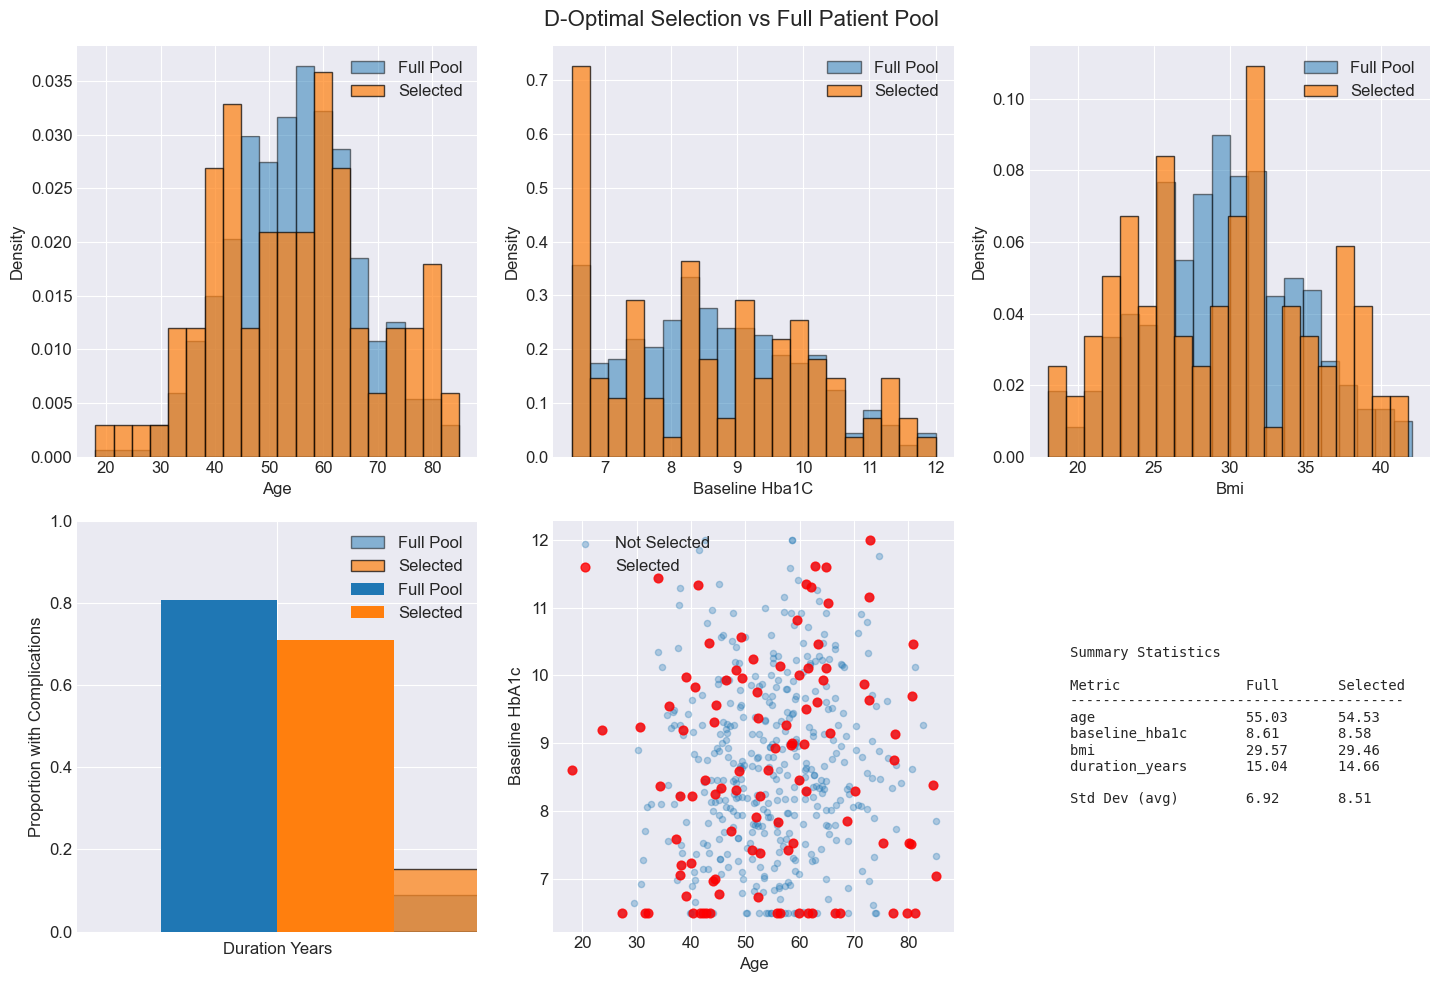


Key Insights from the Optimal Selection:
1. The algorithm tends to select patients that span the full range of characteristics
2. It avoids clustering in any particular region of the patient space
3. The selection maintains diversity while ensuring good coverage


In [5]:
# Compare selected patients with the full pool
def compare_populations(selected_df, full_df, title="Comparison"):
    """
    Compare characteristics between selected and full populations.
    """
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle(title, fontsize=16)
    
    features = ['age', 'baseline_hba1c', 'bmi', 'duration_years']
    
    # Continuous variables - show distributions
    for idx, feature in enumerate(features):
        ax = axes[idx // 3, idx % 3]
        
        # Plot full population
        ax.hist(full_df[feature], bins=20, alpha=0.5, label='Full Pool', 
                density=True, edgecolor='black')
        
        # Plot selected population
        ax.hist(selected_df[feature], bins=20, alpha=0.7, label='Selected', 
                density=True, edgecolor='black')
        
        ax.set_xlabel(feature.replace('_', ' ').title())
        ax.set_ylabel('Density')
        ax.legend()
    
    # Complications - show proportions
    ax = axes[1, 0]
    comp_data = pd.DataFrame({
        'Full Pool': [full_df['has_complications'].mean()],
        'Selected': [selected_df['has_complications'].mean()]
    })
    comp_data.plot(kind='bar', ax=ax, width=0.7)
    ax.set_ylabel('Proportion with Complications')
    ax.set_xticklabels([''], rotation=0)
    ax.set_ylim(0, 1)
    ax.legend()
    
    # Coverage plot - 2D representation of patient space
    ax = axes[1, 1]
    ax.scatter(full_df['age'], full_df['baseline_hba1c'], 
              alpha=0.3, label='Not Selected', s=20)
    ax.scatter(selected_df['age'], selected_df['baseline_hba1c'], 
              alpha=0.8, label='Selected', s=40, color='red')
    ax.set_xlabel('Age')
    ax.set_ylabel('Baseline HbA1c')
    ax.legend()
    
    # Summary statistics table
    ax = axes[1, 2]
    ax.axis('off')
    
    summary_text = "Summary Statistics\n\n"
    summary_text += f"{'Metric':<20} {'Full':<10} {'Selected':<10}\n"
    summary_text += "-" * 40 + "\n"
    
    for feature in features:
        full_mean = full_df[feature].mean()
        sel_mean = selected_df[feature].mean()
        summary_text += f"{feature:<20} {full_mean:<10.2f} {sel_mean:<10.2f}\n"
    
    summary_text += f"\n{'Std Dev (avg)':<20} {full_df[features].std().mean():<10.2f} {selected_df[features].std().mean():<10.2f}"
    
    ax.text(0.1, 0.5, summary_text, transform=ax.transAxes, 
            fontfamily='monospace', fontsize=10, verticalalignment='center')
    
    plt.tight_layout()
    plt.show()

# Compare the populations
compare_populations(selected_patients, patient_pool, 
                   "D-Optimal Selection vs Full Patient Pool")

# Let's also compare with a random selection
random_indices = np.random.choice(len(patient_pool), size=n_select, replace=False)
random_patients = patient_pool.iloc[random_indices]

print("\nKey Insights from the Optimal Selection:")
print("1. The algorithm tends to select patients that span the full range of characteristics")
print("2. It avoids clustering in any particular region of the patient space")
print("3. The selection maintains diversity while ensuring good coverage")

### Understanding the Information Gain

Let's quantify how much better our optimal selection is compared to random selection. We'll look at the determinant of the information matrix, which D-optimality maximizes.

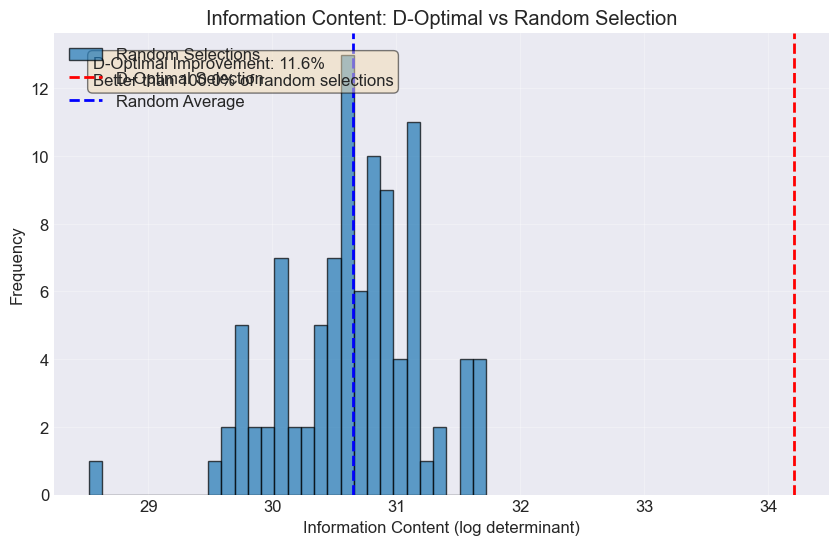


Information Gain Analysis:
D-Optimal selection information: 34.20
Average random selection information: 30.65
Improvement over random: 11.6%

This means our optimally selected patients will provide 11.6% more
statistical information for estimating treatment effects!


In [6]:
def calculate_information_gain(design_matrix, selected_indices):
    """
    Calculate the D-optimality criterion value for a given selection.
    Higher values indicate more information.
    """
    X_selected = design_matrix[selected_indices, :]
    # Information matrix is X'X
    info_matrix = X_selected.T @ X_selected
    # D-optimality is the log determinant
    sign, logdet = np.linalg.slogdet(info_matrix)
    return logdet

# Calculate information for our optimal selection
optimal_info = calculate_information_gain(design_matrix, selected_indices)

# Compare with multiple random selections
n_random_trials = 100
random_info_values = []

for _ in range(n_random_trials):
    random_idx = np.random.choice(len(patient_pool), size=n_select, replace=False)
    random_info = calculate_information_gain(design_matrix, random_idx)
    random_info_values.append(random_info)

random_info_values = np.array(random_info_values)

# Visualize the comparison
plt.figure(figsize=(10, 6))
plt.hist(random_info_values, bins=30, alpha=0.7, label='Random Selections', edgecolor='black')
plt.axvline(optimal_info, color='red', linestyle='--', linewidth=2, label='D-Optimal Selection')
plt.axvline(np.mean(random_info_values), color='blue', linestyle='--', linewidth=2, label='Random Average')

plt.xlabel('Information Content (log determinant)')
plt.ylabel('Frequency')
plt.title('Information Content: D-Optimal vs Random Selection')
plt.legend()
plt.grid(alpha=0.3)

# Calculate improvement
improvement = (optimal_info - np.mean(random_info_values)) / np.mean(random_info_values) * 100
percentile = (random_info_values < optimal_info).sum() / len(random_info_values) * 100

plt.text(0.05, 0.95, f'D-Optimal Improvement: {improvement:.1f}%\nBetter than {percentile:.1f}% of random selections',
         transform=plt.gca().transAxes, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
         verticalalignment='top')

plt.show()

print(f"\nInformation Gain Analysis:")
print(f"D-Optimal selection information: {optimal_info:.2f}")
print(f"Average random selection information: {np.mean(random_info_values):.2f}")
print(f"Improvement over random: {improvement:.1f}%")
print(f"\nThis means our optimally selected patients will provide {improvement:.1f}% more")
print("statistical information for estimating treatment effects!")

## Part 2: Multi-Center Trial Site Selection <a name="part2"></a>

### The Challenge

Now let's consider a different scenario. You're planning a large Phase III trial that will run across multiple clinical sites. Each site has different characteristics:
- Patient recruitment potential
- Experience with similar trials
- Geographic location
- Cost per patient
- Quality metrics

You need to select 15 sites from 50 potential sites to:
1. Ensure adequate patient recruitment
2. Maintain geographic diversity
3. Control costs
4. Ensure high-quality data

This is a **multi-objective optimization problem** - we have multiple goals that may conflict with each other.

Site Pool Summary:
          recruitment_potential         cost_per_patient quality_score
                          count    mean             mean          mean
region                                                                
Midwest                      14   87.71          8947.83         56.37
Northeast                     9   77.67         12363.78         60.66
Southeast                     9   90.22          8859.63         53.13
Southwest                    12  108.67          9551.27         59.52
West                          6   91.50         10676.56         54.24


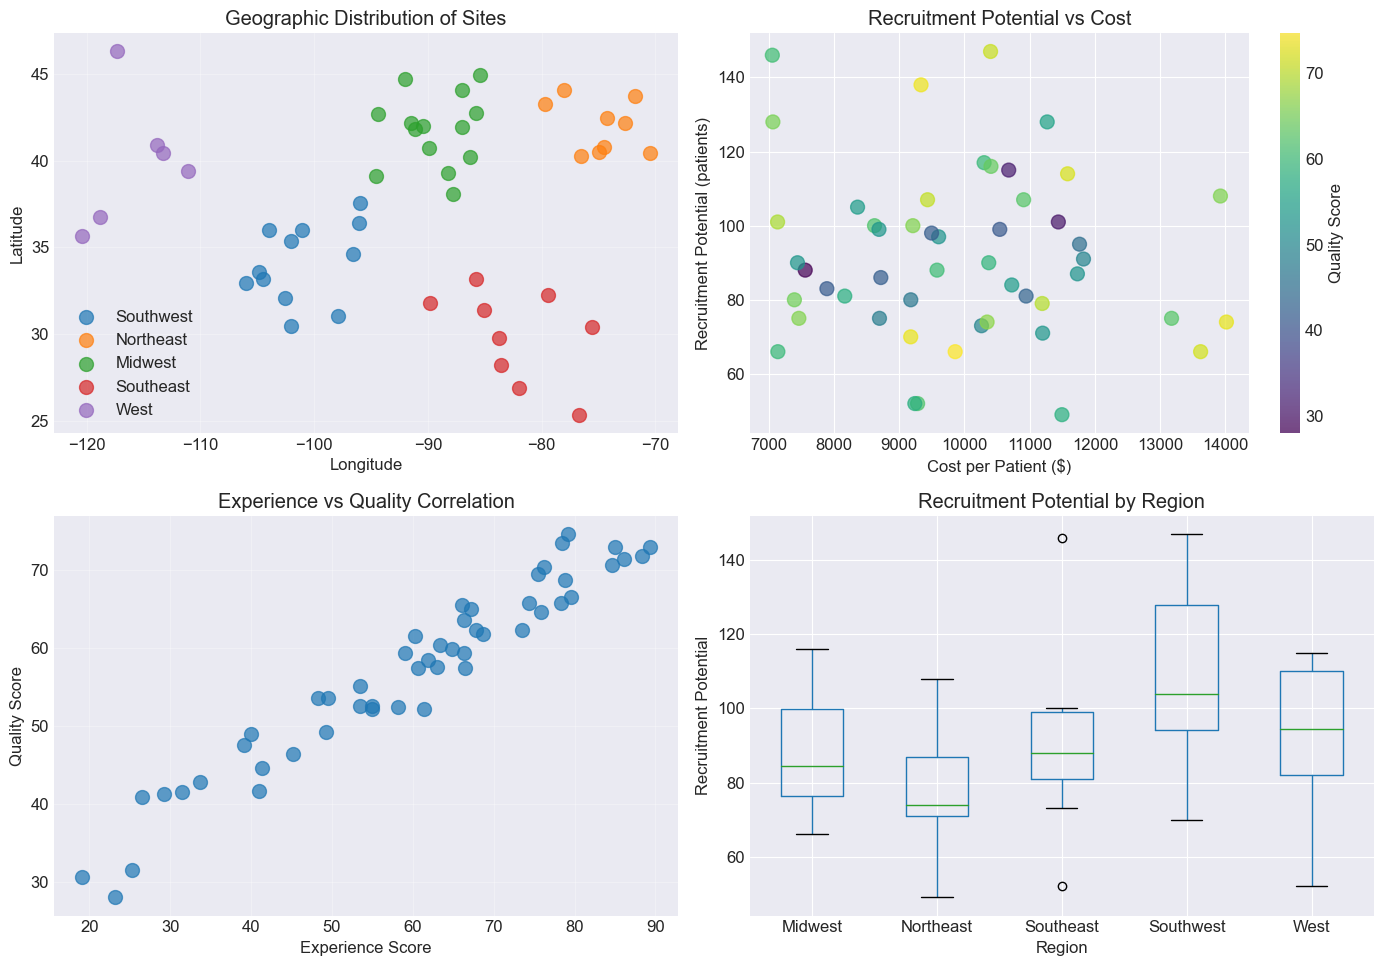

In [7]:
# Generate synthetic site data
def generate_site_data(n_sites=50):
    """
    Generate realistic clinical trial site data.
    """
    # Define regions
    regions = ['Northeast', 'Southeast', 'Midwest', 'Southwest', 'West']
    
    # Generate site characteristics
    sites = []
    
    for i in range(n_sites):
        region = np.random.choice(regions)
        
        # Regional variations in characteristics
        if region == 'Northeast':
            recruitment_base = 80
            cost_base = 12000
        elif region == 'Southeast':
            recruitment_base = 100
            cost_base = 9000
        elif region == 'Midwest':
            recruitment_base = 90
            cost_base = 8500
        elif region == 'Southwest':
            recruitment_base = 110
            cost_base = 9500
        else:  # West
            recruitment_base = 95
            cost_base = 11000
        
        # Add variability
        recruitment_potential = int(np.random.normal(recruitment_base, 20))
        recruitment_potential = max(30, recruitment_potential)  # Minimum 30 patients
        
        # Experience score (0-100)
        experience = np.random.beta(5, 3) * 100  # Skewed towards higher experience
        
        # Cost per patient
        cost_per_patient = np.random.normal(cost_base, 1500)
        cost_per_patient = max(5000, cost_per_patient)
        
        # Quality score (0-100) - correlates with experience
        quality = 0.6 * experience + 0.4 * np.random.normal(50, 10)
        quality = np.clip(quality, 0, 100)
        
        # Geographic coordinates (simplified)
        if region == 'Northeast':
            lat = np.random.uniform(40, 45)
            lon = np.random.uniform(-80, -70)
        elif region == 'Southeast':
            lat = np.random.uniform(25, 35)
            lon = np.random.uniform(-90, -75)
        elif region == 'Midwest':
            lat = np.random.uniform(38, 45)
            lon = np.random.uniform(-95, -85)
        elif region == 'Southwest':
            lat = np.random.uniform(30, 38)
            lon = np.random.uniform(-110, -95)
        else:  # West
            lat = np.random.uniform(32, 48)
            lon = np.random.uniform(-125, -110)
        
        sites.append({
            'site_id': f'SITE_{i+1:03d}',
            'region': region,
            'recruitment_potential': recruitment_potential,
            'experience_score': experience,
            'cost_per_patient': cost_per_patient,
            'quality_score': quality,
            'latitude': lat,
            'longitude': lon
        })
    
    return pd.DataFrame(sites)

# Generate site data
site_pool = generate_site_data(50)

print("Site Pool Summary:")
print(site_pool.groupby('region').agg({
    'recruitment_potential': ['count', 'mean'],
    'cost_per_patient': 'mean',
    'quality_score': 'mean'
}).round(2))

# Visualize site characteristics
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Geographic distribution
ax = axes[0, 0]
for region in site_pool['region'].unique():
    region_data = site_pool[site_pool['region'] == region]
    ax.scatter(region_data['longitude'], region_data['latitude'], 
              label=region, s=100, alpha=0.7)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Geographic Distribution of Sites')
ax.legend()
ax.grid(True, alpha=0.3)

# Recruitment vs Cost
ax = axes[0, 1]
scatter = ax.scatter(site_pool['cost_per_patient'], 
                    site_pool['recruitment_potential'],
                    c=site_pool['quality_score'], 
                    cmap='viridis', s=100, alpha=0.7)
ax.set_xlabel('Cost per Patient ($)')
ax.set_ylabel('Recruitment Potential (patients)')
ax.set_title('Recruitment Potential vs Cost')
plt.colorbar(scatter, ax=ax, label='Quality Score')

# Experience vs Quality
ax = axes[1, 0]
ax.scatter(site_pool['experience_score'], site_pool['quality_score'], 
          s=100, alpha=0.7)
ax.set_xlabel('Experience Score')
ax.set_ylabel('Quality Score')
ax.set_title('Experience vs Quality Correlation')
ax.grid(True, alpha=0.3)

# Regional recruitment potential
ax = axes[1, 1]
site_pool.boxplot(column='recruitment_potential', by='region', ax=ax)
ax.set_xlabel('Region')
ax.set_ylabel('Recruitment Potential')
ax.set_title('Recruitment Potential by Region')
plt.suptitle('')  # Remove the automatic title

plt.tight_layout()
plt.show()

### Multi-Objective Optimization Function

For site selection, we need to balance multiple objectives:
1. **Maximize total recruitment potential**
2. **Minimize total cost**
3. **Maximize geographic diversity**
4. **Maximize average quality**

Let's define a multi-objective function that considers all these factors.

In [8]:
def site_selection_objectives(selected_indices, data):
    """
    Multi-objective function for site selection.
    Returns a list of objective values to be maximized.
    """
    sites_df = data['sites_df']
    selected_sites = sites_df.iloc[selected_indices]
    
    # Objective 1: Total recruitment potential (maximize)
    total_recruitment = selected_sites['recruitment_potential'].sum()
    
    # Objective 2: Total cost (minimize -> negate to maximize)
    # Assuming we'll recruit 80% of potential from each site
    expected_patients_per_site = selected_sites['recruitment_potential'] * 0.8
    total_cost = (expected_patients_per_site * selected_sites['cost_per_patient']).sum()
    # Negate and scale to make it comparable to other objectives
    cost_objective = -total_cost / 1000000  # Convert to millions and negate
    
    # Objective 3: Geographic diversity (maximize)
    # Calculate as the average pairwise distance between selected sites
    from scipy.spatial.distance import pdist
    coords = selected_sites[['latitude', 'longitude']].values
    if len(coords) > 1:
        distances = pdist(coords, metric='euclidean')
        geographic_diversity = np.mean(distances)
    else:
        geographic_diversity = 0
    
    # Objective 4: Average quality score (maximize)
    avg_quality = selected_sites['quality_score'].mean()
    
    # Scale objectives to similar ranges for better optimization
    return [
        total_recruitment / 100,     # Scale to ~10-20 range
        cost_objective,              # Already scaled
        geographic_diversity,        # Already in reasonable range
        avg_quality / 10            # Scale to ~5-10 range
    ]

# Prepare data for TrainSelPy
site_features = site_pool[['recruitment_potential', 'cost_per_patient', 
                          'quality_score', 'latitude', 'longitude']].values

ts_site_data = make_data(M=site_features)
ts_site_data['sites_df'] = site_pool

# Configure optimization for multi-objective
control_multi = train_sel_control(
    niterations=150,
    npop=300,
    nelite=100,
    nEliteSaved=30,  # Save more solutions for Pareto front
    mutprob=0.1,
    crossprob=0.8,
    progress=True
)

print("Running multi-objective optimization for site selection...")
print("Objectives:")
print("1. Maximize total recruitment potential")
print("2. Minimize total cost")
print("3. Maximize geographic diversity")
print("4. Maximize average quality\n")

# Run multi-objective optimization
result_sites = train_sel(
    data=ts_site_data,
    candidates=[list(range(len(site_pool)))],
    setsizes=[15],  # Select 15 sites
    settypes=["UOS"],
    stat=site_selection_objectives,
    n_stat=4,  # Number of objectives
    control=control_multi,
    verbose=True
)

print(f"\nOptimization complete!")
print(f"Found {len(result_sites.pareto_front) if result_sites.pareto_front else 0} solutions on the Pareto front")

Running multi-objective optimization for site selection...
Objectives:
1. Maximize total recruitment potential
2. Minimize total cost
3. Maximize geographic diversity
4. Maximize average quality

Starting TrainSelPy optimization
Starting GA with population size 300
Initial best fitness: 32.330465628106076
Generation 0: Best fitness = 33.3477644669023
Generation 10: Best fitness = 33.49350068705013
Generation 20: Best fitness = 33.65308788770681
Generation 30: Best fitness = 34.169780374780736
Generation 40: Best fitness = 34.169780374780736
Generation 50: Best fitness = 34.20924485026988
Generation 60: Best fitness = 34.39212063257571
Generation 70: Best fitness = 34.39212063257571
Generation 80: Best fitness = 34.39212063257571
Generation 90: Best fitness = 34.39212063257571
Generation 100: Best fitness = 34.39212063257571
Generation 110: Best fitness = 34.39212063257571
Generation 120: Best fitness = 34.39212063257571
Generation 130: Best fitness = 34.39212063257571
Generation 140: B

### Analyzing the Pareto Front

In multi-objective optimization, there's typically no single "best" solution. Instead, we get a **Pareto front** - a set of solutions where improving one objective would worsen another. Let's explore these trade-offs.

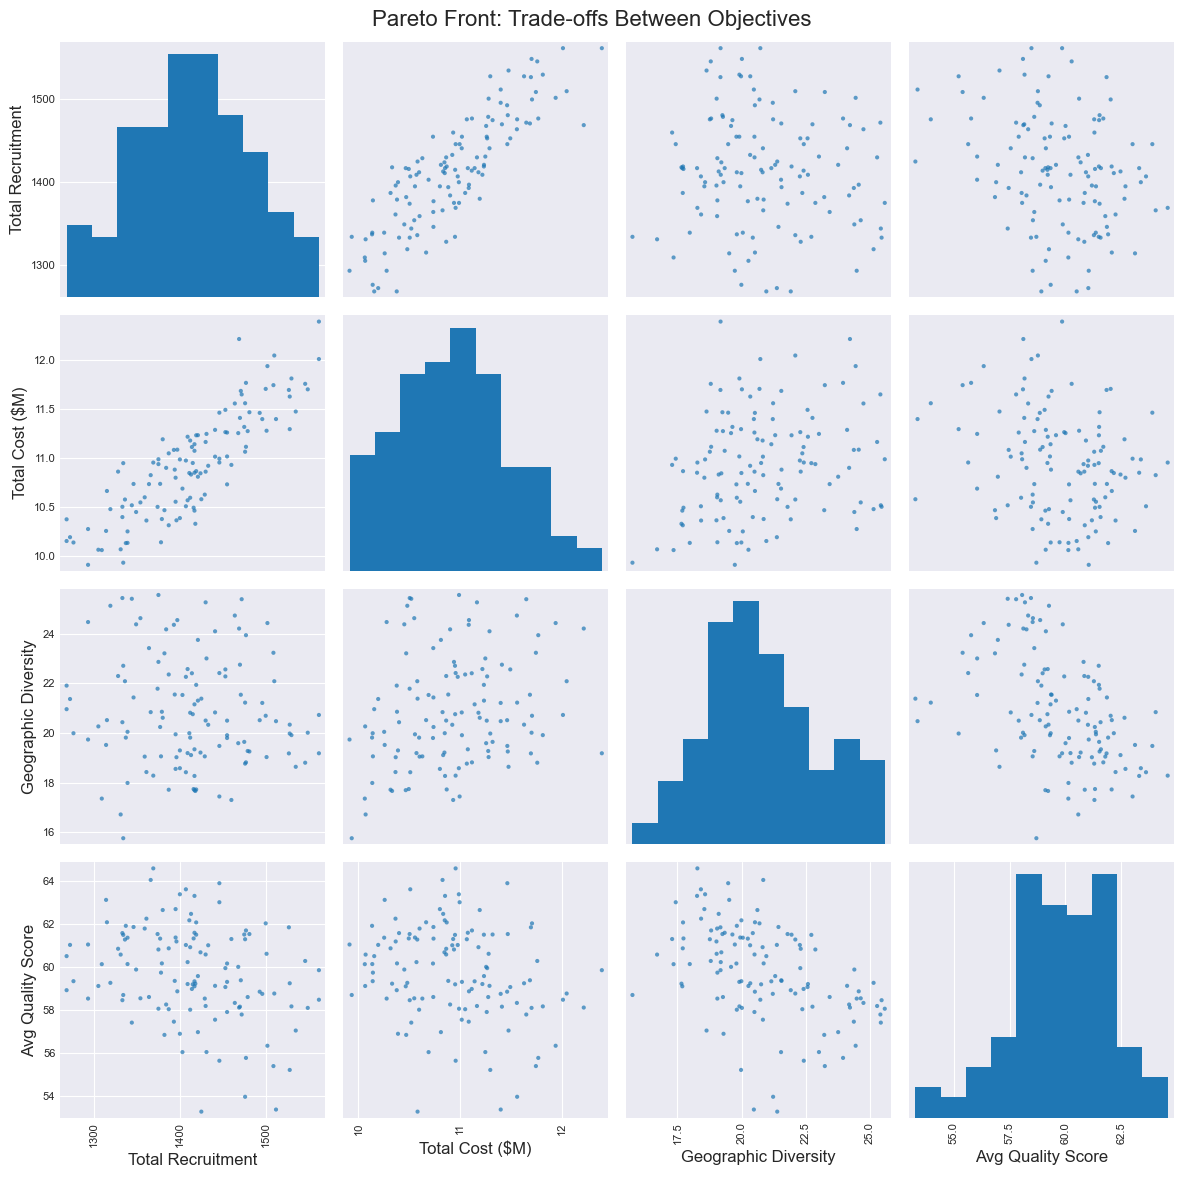


Key Solutions from the Pareto Front:

Minimum Cost:
  Total Recruitment: 1293 patients
  Total Cost: $9.91M
  Geographic Diversity: 19.73
  Average Quality: 61.0

Maximum Recruitment:
  Total Recruitment: 1562 patients
  Total Cost: $12.01M
  Geographic Diversity: 20.73
  Average Quality: 58.5

Maximum Quality:
  Total Recruitment: 1369 patients
  Total Cost: $10.95M
  Geographic Diversity: 18.28
  Average Quality: 64.6

Balanced Solution:
  Total Recruitment: 1407 patients
  Total Cost: $10.98M
  Geographic Diversity: 22.27
  Average Quality: 61.0



In [9]:
if result_sites.pareto_front:
    # Extract objective values from Pareto front
    pareto_objectives = np.array(result_sites.pareto_front)
    
    # Rescale objectives back to original units for interpretation
    recruitment_values = pareto_objectives[:, 0] * 100
    cost_values = -pareto_objectives[:, 1] * 1000000  # Convert back to positive dollars
    diversity_values = pareto_objectives[:, 2]
    quality_values = pareto_objectives[:, 3] * 10
    
    # Create scatter matrix of objectives
    objectives_df = pd.DataFrame({
        'Total Recruitment': recruitment_values,
        'Total Cost ($M)': cost_values / 1000000,
        'Geographic Diversity': diversity_values,
        'Avg Quality Score': quality_values
    })
    
    # Plot pairwise relationships
    pd.plotting.scatter_matrix(objectives_df, figsize=(12, 12), alpha=0.7, diagonal='hist')
    plt.suptitle('Pareto Front: Trade-offs Between Objectives', fontsize=16)
    plt.tight_layout()
    plt.show()
    
    # Find specific solutions of interest
    min_cost_idx = np.argmin(cost_values)
    max_recruitment_idx = np.argmax(recruitment_values)
    max_quality_idx = np.argmax(quality_values)
    
    # Balanced solution (closest to ideal point in normalized space)
    normalized_objectives = (pareto_objectives - pareto_objectives.min(axis=0)) / \
                          (pareto_objectives.max(axis=0) - pareto_objectives.min(axis=0) + 1e-10)
    # Ideal point would be [1, 1, 1, 1] in normalized space
    distances_to_ideal = np.sqrt(((1 - normalized_objectives)**2).sum(axis=1))
    balanced_idx = np.argmin(distances_to_ideal)
    
    # Display key solutions
    print("\nKey Solutions from the Pareto Front:\n")
    
    solutions = [
        (min_cost_idx, "Minimum Cost"),
        (max_recruitment_idx, "Maximum Recruitment"),
        (max_quality_idx, "Maximum Quality"),
        (balanced_idx, "Balanced Solution")
    ]
    
    for idx, name in solutions:
        print(f"{name}:")
        print(f"  Total Recruitment: {recruitment_values[idx]:.0f} patients")
        print(f"  Total Cost: ${cost_values[idx]/1000000:.2f}M")
        print(f"  Geographic Diversity: {diversity_values[idx]:.2f}")
        print(f"  Average Quality: {quality_values[idx]:.1f}")
        print()

### Visualizing Selected Sites

Let's visualize the balanced solution to see which sites were selected and how they're distributed.

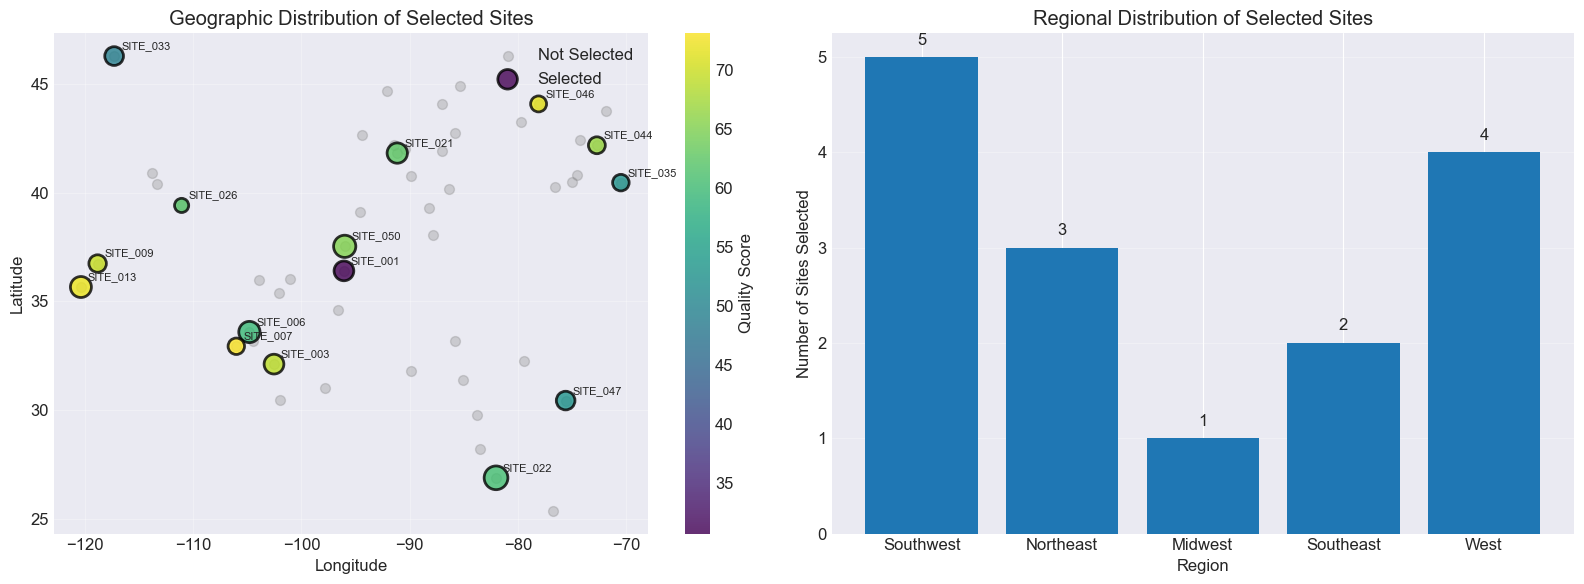


Selected Sites Summary:
 site_id    region  recruitment_potential  cost_per_patient  quality_score
SITE_001 Southwest                    101      11439.850078      30.687100
SITE_003 Southwest                    101       7137.417775      68.817505
SITE_006 Southwest                    117      10302.404616      59.419056
SITE_007 Southwest                     70       9177.534634      73.069001
SITE_009      West                     79      11192.404065      69.544645
SITE_013      West                    114      11581.557481      71.868749
SITE_021   Midwest                    107      10908.014498      62.357285
SITE_022 Southeast                    146       7056.862564      60.385051
SITE_026      West                     52       9283.330425      61.865394
SITE_033      West                     91      11825.410581      49.032832
SITE_035 Northeast                     71      11199.206025      52.464640
SITE_044 Northeast                     74      10348.261823      66.560133


In [10]:
# Get the balanced solution
balanced_solution = result_sites.pareto_solutions[balanced_idx]
selected_site_indices = balanced_solution['selected_indices'][0]
selected_sites = site_pool.iloc[selected_site_indices]

# Create visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Geographic distribution
# Plot all sites
ax1.scatter(site_pool['longitude'], site_pool['latitude'], 
           s=50, alpha=0.3, color='gray', label='Not Selected')

# Plot selected sites with size proportional to recruitment potential
scatter = ax1.scatter(selected_sites['longitude'], selected_sites['latitude'],
                     s=selected_sites['recruitment_potential']*2,
                     c=selected_sites['quality_score'],
                     cmap='viridis', alpha=0.8, edgecolors='black',
                     linewidth=2, label='Selected')

# Add site labels
for _, site in selected_sites.iterrows():
    ax1.annotate(site['site_id'], (site['longitude'], site['latitude']),
                xytext=(5, 5), textcoords='offset points', fontsize=8)

ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
ax1.set_title('Geographic Distribution of Selected Sites')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Colorbar for quality
cbar = plt.colorbar(scatter, ax=ax1)
cbar.set_label('Quality Score')

# Regional distribution bar chart
region_counts = selected_sites['region'].value_counts()
all_regions = site_pool['region'].unique()
region_data = pd.Series([region_counts.get(r, 0) for r in all_regions], index=all_regions)

bars = ax2.bar(region_data.index, region_data.values)
ax2.set_xlabel('Region')
ax2.set_ylabel('Number of Sites Selected')
ax2.set_title('Regional Distribution of Selected Sites')
ax2.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, value in zip(bars, region_data.values):
    if value > 0:
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                f'{int(value)}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Summary statistics
print("\nSelected Sites Summary:")
print(selected_sites[['site_id', 'region', 'recruitment_potential', 
                      'cost_per_patient', 'quality_score']].to_string(index=False))

print(f"\nTotal expected recruitment: {selected_sites['recruitment_potential'].sum()} patients")
print(f"Average cost per patient: ${selected_sites['cost_per_patient'].mean():.2f}")
print(f"Average quality score: {selected_sites['quality_score'].mean():.1f}")

## Part 3: Dose-Finding Study Design <a name="part3"></a>

### The Challenge

In early-phase clinical trials, one of the most critical decisions is selecting which doses to test. Traditional approaches often use equally spaced doses on a log scale, but this may not be optimal for:
- Identifying the minimum effective dose
- Characterizing the dose-response relationship
- Finding the maximum tolerated dose
- Balancing efficacy and safety

Let's design an optimal dose-finding study that efficiently explores the dose-response space while minimizing patient exposure to ineffective or unsafe doses.

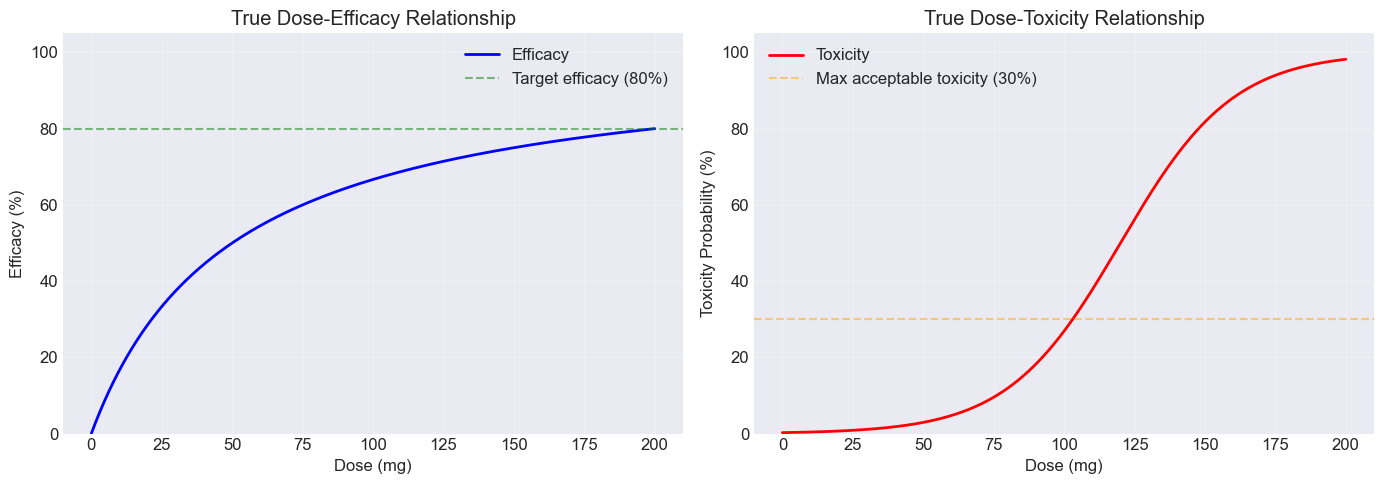

True optimal dose (unknown to investigators): 102.9 mg
Efficacy at optimal dose: 67.3%
Toxicity at optimal dose: 29.8%


In [11]:
# Simulate a dose-response relationship
def true_dose_response(dose, model='emax'):
    """
    Simulate true dose-response relationships for efficacy and toxicity.
    """
    if model == 'emax':
        # Emax model for efficacy
        emax = 100  # Maximum effect
        ed50 = 50   # Dose producing 50% of maximum effect
        efficacy = (emax * dose) / (ed50 + dose)
        
        # Sigmoidal model for toxicity
        # Toxicity increases more steeply at higher doses
        toxicity = 100 / (1 + np.exp(-0.05 * (dose - 120)))
        
    return efficacy, toxicity

# Visualize the true dose-response curves
doses = np.linspace(0, 200, 1000)
efficacy_values = []
toxicity_values = []

for d in doses:
    eff, tox = true_dose_response(d)
    efficacy_values.append(eff)
    toxicity_values.append(tox)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Efficacy curve
ax1.plot(doses, efficacy_values, 'b-', linewidth=2, label='Efficacy')
ax1.axhline(y=80, color='g', linestyle='--', alpha=0.5, label='Target efficacy (80%)')
ax1.set_xlabel('Dose (mg)')
ax1.set_ylabel('Efficacy (%)')
ax1.set_title('True Dose-Efficacy Relationship')
ax1.grid(True, alpha=0.3)
ax1.legend()
ax1.set_ylim(0, 105)

# Safety curve
ax2.plot(doses, toxicity_values, 'r-', linewidth=2, label='Toxicity')
ax2.axhline(y=30, color='orange', linestyle='--', alpha=0.5, label='Max acceptable toxicity (30%)')
ax2.set_xlabel('Dose (mg)')
ax2.set_ylabel('Toxicity Probability (%)')
ax2.set_title('True Dose-Toxicity Relationship')
ax2.grid(True, alpha=0.3)
ax2.legend()
ax2.set_ylim(0, 105)

plt.tight_layout()
plt.show()

# Find the optimal dose (best efficacy with acceptable toxicity)
utility = np.array(efficacy_values) - 2 * np.maximum(0, np.array(toxicity_values) - 30)
optimal_dose_idx = np.argmax(utility)
optimal_dose = doses[optimal_dose_idx]

print(f"True optimal dose (unknown to investigators): {optimal_dose:.1f} mg")
print(f"Efficacy at optimal dose: {efficacy_values[optimal_dose_idx]:.1f}%")
print(f"Toxicity at optimal dose: {toxicity_values[optimal_dose_idx]:.1f}%")

### Optimal Dose Selection Using D-Optimality

Now let's use D-optimality to select doses that will give us the most information about the dose-response relationship. We'll create a design matrix that includes basis functions for modeling the dose-response curve.

In [12]:
def create_dose_design_matrix(doses, basis='polynomial'):
    """
    Create a design matrix for dose-response modeling.
    """
    doses = np.array(doses).reshape(-1, 1)
    
    if basis == 'polynomial':
        # Polynomial basis up to degree 3
        X = np.hstack([
            np.ones_like(doses),                    # Intercept
            doses,                                  # Linear term
            doses**2,                              # Quadratic term
            doses**3,                              # Cubic term
        ])
    elif basis == 'emax':
        # Basis functions for Emax model (linearized)
        X = np.hstack([
            np.ones_like(doses),                    # Intercept
            doses,                                  # Dose
            1 / (doses + 50),                      # Emax-like term (ED50=50)
            np.log(doses + 1),                     # Log term for flexibility
        ])
    
    # Standardize to improve numerical stability
    X[:, 1:] = (X[:, 1:] - X[:, 1:].mean(axis=0)) / X[:, 1:].std(axis=0)
    
    return X

# Define candidate doses (e.g., every 5mg from 5 to 200)
candidate_doses = np.arange(5, 201, 5)
n_doses_to_select = 6  # Select 6 doses for the study

# Create design matrix for all candidate doses
dose_design_matrix = create_dose_design_matrix(candidate_doses, basis='polynomial')

# Prepare data for TrainSelPy
ts_dose_data = make_data(M=dose_design_matrix)
ts_dose_data["FeatureMat"] = dose_design_matrix
ts_dose_data["doses"] = candidate_doses

# Run D-optimal design
control_dose = train_sel_control(
    niterations=100,
    npop=200,
    nelite=50,
    progress=True
)

print(f"Selecting {n_doses_to_select} optimal doses from {len(candidate_doses)} candidates...\n")

result_doses = train_sel(
    data=ts_dose_data,
    candidates=[list(range(len(candidate_doses)))],
    setsizes=[n_doses_to_select],
    settypes=["UOS"],
    stat=dopt,
    control=control_dose,
    verbose=True
)

# Extract selected doses
selected_dose_indices = result_doses.selected_indices[0]
selected_doses = candidate_doses[selected_dose_indices]

print(f"\nD-Optimal doses selected: {sorted(selected_doses)} mg")

Selecting 6 optimal doses from 40 candidates...

Starting TrainSelPy optimization
Starting GA with population size 200
Initial best fitness: 2.9444389791664403
Generation 0: Best fitness = 2.9444389791664403
Generation 10: Best fitness = 2.9444389791664403
Generation 20: Best fitness = 2.9444389791664403
Generation 30: Best fitness = 2.9444389791664403
Generation 40: Best fitness = 2.9444389791664403
Generation 50: Best fitness = 2.9444389791664403
Generation 60: Best fitness = 2.9444389791664403
Generation 70: Best fitness = 2.9444389791664403
Generation 80: Best fitness = 2.9444389791664403
Generation 90: Best fitness = 2.9444389791664403
Optimization completed in 2.59 seconds
Final fitness: 2.9444389791664403

D-Optimal doses selected: [40, 80, 175, 190, 195, 200] mg


### Comparing Optimal vs Traditional Dose Selection

Let's compare our D-optimal dose selection with traditional approaches to see the advantages.

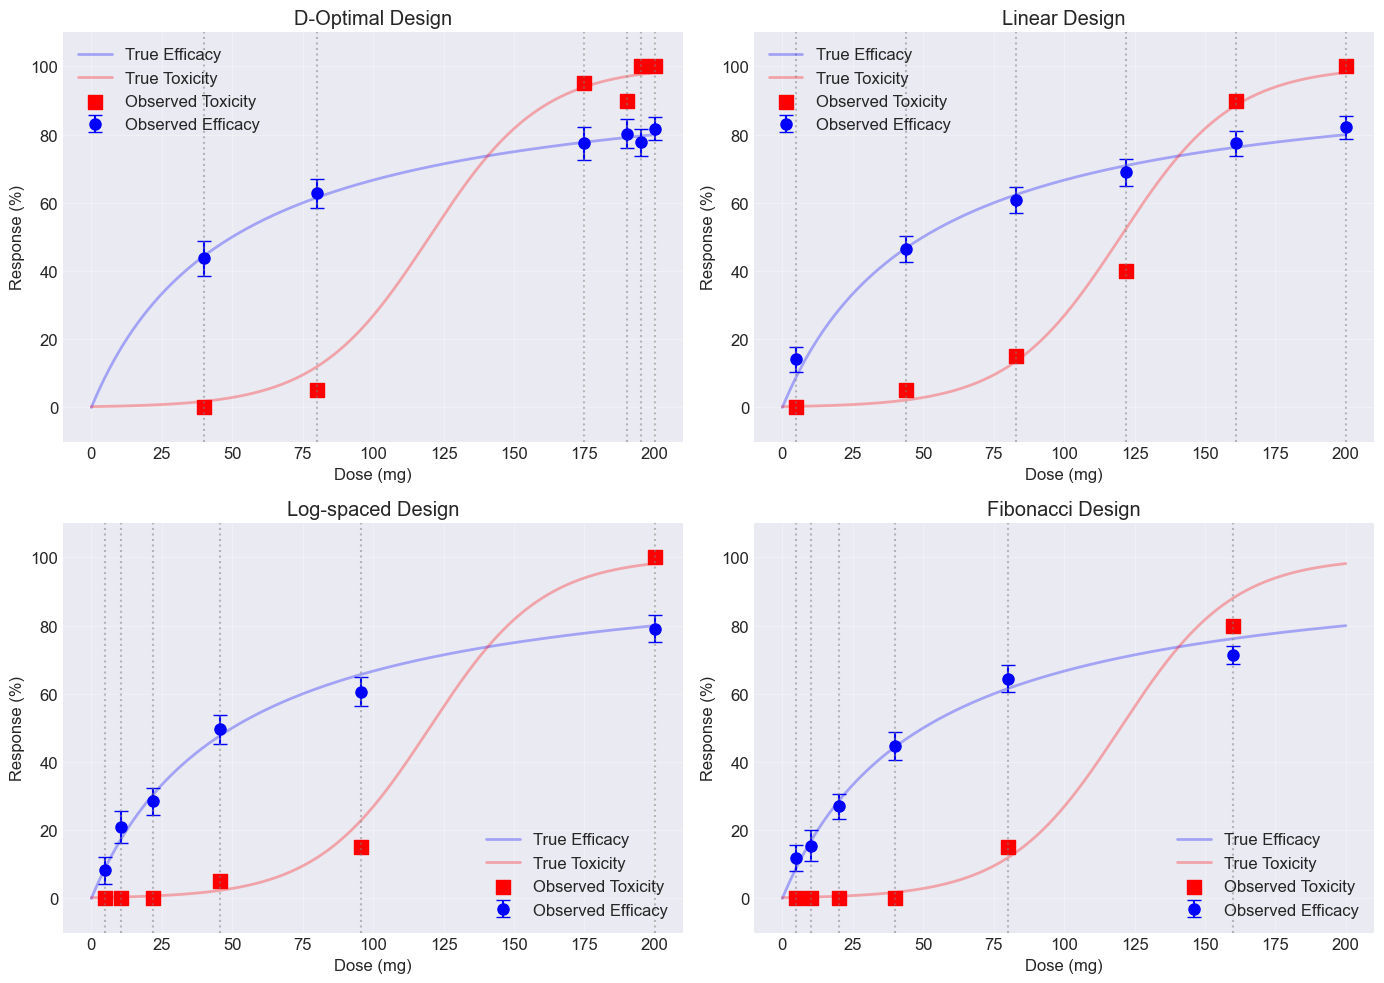


Information Content Comparison:
D-Optimal: 2.94
Linear: -33.07
Log-spaced: -32.51
Fibonacci: -inf


In [13]:
# Traditional dose selections for comparison
# 1. Equally spaced on linear scale
linear_doses = np.linspace(5, 200, n_doses_to_select)

# 2. Equally spaced on log scale (common in dose-finding)
log_doses = np.exp(np.linspace(np.log(5), np.log(200), n_doses_to_select))

# 3. Modified Fibonacci sequence (common in oncology)
fib_doses = [5, 10, 20, 40, 80, 160]

# Simulate what we would learn from each design
def simulate_dose_finding_study(doses, n_patients_per_dose=20, noise_sd=10):
    """
    Simulate outcomes for a dose-finding study.
    """
    results = []
    
    for dose in doses:
        true_eff, true_tox = true_dose_response(dose)
        
        # Simulate patient responses
        observed_eff = np.random.normal(true_eff, noise_sd, n_patients_per_dose)
        observed_tox = np.random.binomial(1, true_tox/100, n_patients_per_dose)
        
        results.append({
            'dose': dose,
            'mean_efficacy': observed_eff.mean(),
            'se_efficacy': observed_eff.std() / np.sqrt(n_patients_per_dose),
            'toxicity_rate': observed_tox.mean() * 100,
            'n_toxic': observed_tox.sum()
        })
    
    return pd.DataFrame(results)

# Simulate studies with each design
designs = {
    'D-Optimal': sorted(selected_doses),
    'Linear': linear_doses,
    'Log-spaced': log_doses,
    'Fibonacci': fib_doses
}

# Visualize the different designs
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, (name, doses) in enumerate(designs.items()):
    ax = axes[idx]
    
    # Plot true curves
    dose_range = np.linspace(0, 200, 1000)
    eff_true = [true_dose_response(d)[0] for d in dose_range]
    tox_true = [true_dose_response(d)[1] for d in dose_range]
    
    ax.plot(dose_range, eff_true, 'b-', alpha=0.3, linewidth=2, label='True Efficacy')
    ax.plot(dose_range, tox_true, 'r-', alpha=0.3, linewidth=2, label='True Toxicity')
    
    # Simulate study results
    study_results = simulate_dose_finding_study(doses)
    
    # Plot observed data
    ax.errorbar(study_results['dose'], study_results['mean_efficacy'],
               yerr=1.96*study_results['se_efficacy'],
               fmt='bo', markersize=8, capsize=5, label='Observed Efficacy')
    
    ax.scatter(study_results['dose'], study_results['toxicity_rate'],
              color='red', s=100, marker='s', label='Observed Toxicity')
    
    # Mark selected doses
    for dose in doses:
        ax.axvline(x=dose, color='gray', linestyle=':', alpha=0.5)
    
    ax.set_xlabel('Dose (mg)')
    ax.set_ylabel('Response (%)')
    ax.set_title(f'{name} Design')
    ax.grid(True, alpha=0.3)
    ax.legend(loc='best')
    ax.set_ylim(-10, 110)

plt.tight_layout()
plt.show()

# Compare information content
print("\nInformation Content Comparison:")
for name, doses in designs.items():
    # Find closest indices in candidate doses
    indices = [np.argmin(np.abs(candidate_doses - d)) for d in doses]
    info = calculate_information_gain(dose_design_matrix, indices)
    print(f"{name}: {info:.2f}")

## Part 4: Biomarker-Driven Patient Selection <a name="part4"></a>

### The Challenge

Modern precision medicine often involves selecting patients based on biomarkers. However, with multiple biomarkers and limited resources, we need to optimize:
- Which biomarker combinations to use for patient selection
- How to balance enrichment (selecting likely responders) with diversity
- How to ensure we learn about treatment effects across biomarker subgroups

Let's design a biomarker-stratified trial that maximizes our ability to identify which patients benefit most from treatment.

Biomarker Patient Population Summary:
       gene_expression  protein_level  mutation_status  benefit_score  \
count      1000.000000    1000.000000      1000.000000    1000.000000   
mean         22.916806      14.187034         0.517000       0.852471   
std          12.396600       8.696381         0.499961       0.511061   
min           3.972384       0.000000         0.000000       0.124101   
25%          14.529851       8.574824         0.000000       0.439748   
50%          20.341241      12.815031         1.000000       0.739658   
75%          27.770435      18.095283         1.000000       1.205465   
max         137.877519      91.474395         1.000000       4.825713   

       response_probability  
count           1000.000000  
mean               0.634579  
std                0.184573  
min                0.320430  
25%                0.469910  
50%                0.617586  
75%                0.803912  
max                0.999825  

Mutation prevalence: 51.7%

Cell 

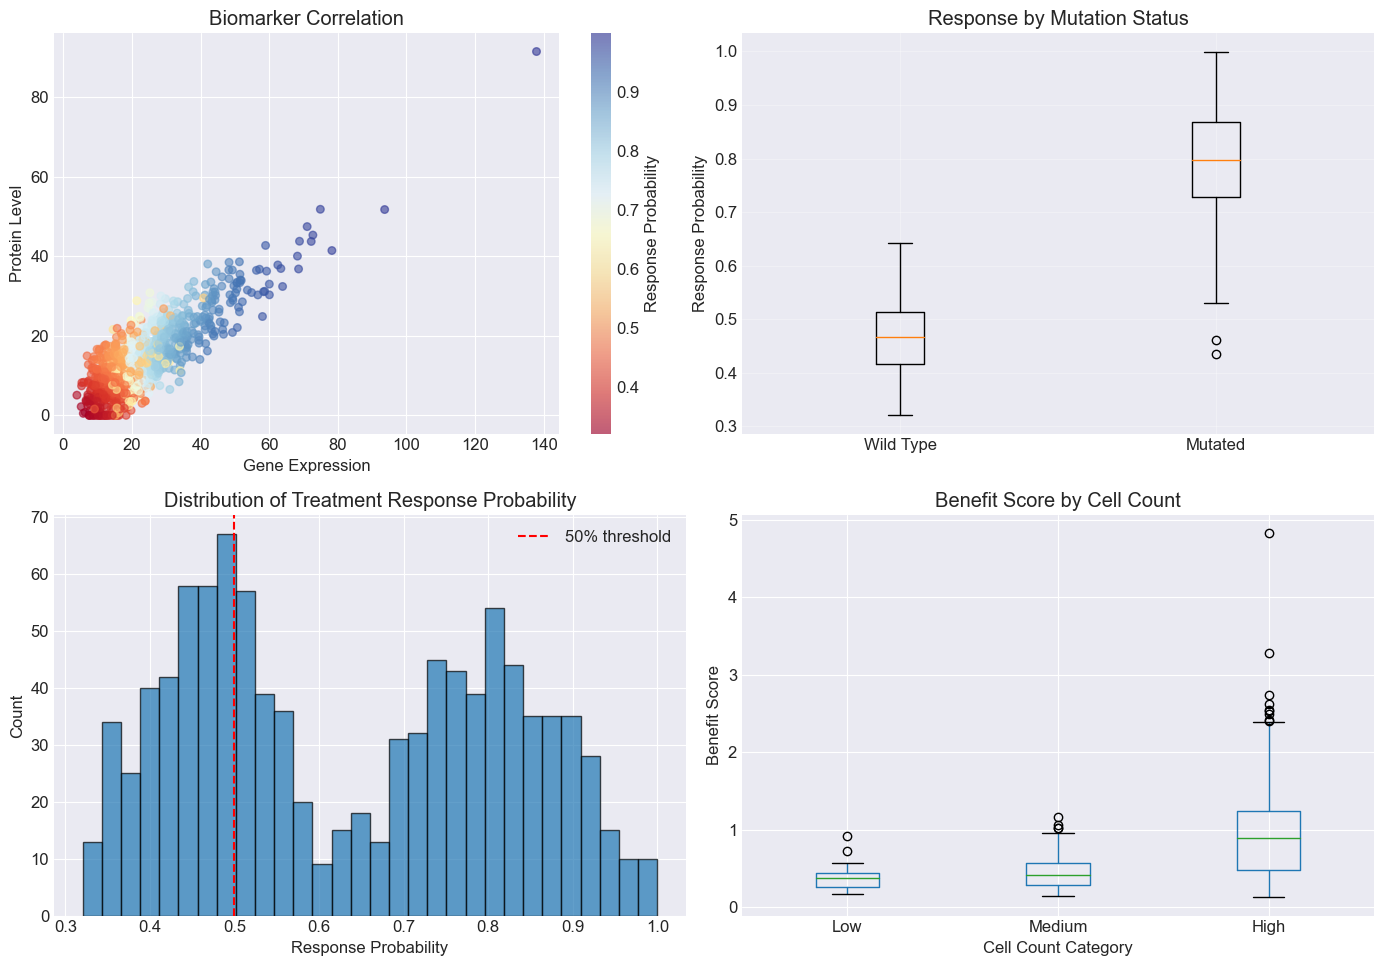

In [14]:
# Generate patient data with biomarkers
def generate_biomarker_patients(n_patients=1000):
    """
    Generate patients with multiple biomarkers that affect treatment response.
    """
    np.random.seed(42)
    
    # Generate correlated biomarkers
    # Biomarker 1: Gene expression (continuous, log-normal)
    biomarker1 = np.random.lognormal(3, 0.5, n_patients)
    
    # Biomarker 2: Protein level (continuous, correlated with gene expression)
    biomarker2 = 0.6 * biomarker1 + np.random.normal(0, 5, n_patients)
    biomarker2 = np.maximum(0, biomarker2)
    
    # Biomarker 3: Mutation status (binary)
    # Probability of mutation increases with biomarker1
    mutation_prob = 1 / (1 + np.exp(-0.3 * (biomarker1 - 20)))
    biomarker3 = np.random.binomial(1, mutation_prob)
    
    # Biomarker 4: Cell count (discrete categories)
    # Low, Medium, High based on a latent continuous variable
    latent = np.random.normal(0, 1, n_patients) + 0.1 * biomarker1
    biomarker4 = pd.cut(latent, bins=[-np.inf, -0.5, 0.5, np.inf], 
                        labels=['Low', 'Medium', 'High'])
    
    # True treatment benefit depends on biomarkers
    # Complex interaction: patients benefit most when:
    # - High biomarker1 AND mutation present
    # - OR moderate biomarker2 regardless of mutation
    benefit_score = (
        0.3 * (biomarker1 / 20) +                    # Linear effect of biomarker1
        0.4 * biomarker3 * (biomarker1 / 20) +       # Interaction effect
        0.3 * np.exp(-((biomarker2 - 15) / 10)**2)   # Optimal range for biomarker2
    )
    
    # Add noise and create binary response
    true_response_prob = 1 / (1 + np.exp(-2 * (benefit_score - 0.5)))
    
    # Create DataFrame
    patients = pd.DataFrame({
        'patient_id': [f'BM{i:04d}' for i in range(n_patients)],
        'gene_expression': biomarker1,
        'protein_level': biomarker2,
        'mutation_status': biomarker3,
        'cell_count': biomarker4,
        'benefit_score': benefit_score,
        'response_probability': true_response_prob
    })
    
    return patients

# Generate biomarker patient data
biomarker_patients = generate_biomarker_patients(1000)

print("Biomarker Patient Population Summary:")
print(biomarker_patients.describe())
print(f"\nMutation prevalence: {biomarker_patients['mutation_status'].mean()*100:.1f}%")
print("\nCell count distribution:")
print(biomarker_patients['cell_count'].value_counts())

# Visualize biomarker relationships
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Gene expression vs protein level
scatter = axes[0, 0].scatter(biomarker_patients['gene_expression'], 
                            biomarker_patients['protein_level'],
                            c=biomarker_patients['response_probability'],
                            cmap='RdYlBu', alpha=0.6, s=30)
axes[0, 0].set_xlabel('Gene Expression')
axes[0, 0].set_ylabel('Protein Level')
axes[0, 0].set_title('Biomarker Correlation')
plt.colorbar(scatter, ax=axes[0, 0], label='Response Probability')

# Response by mutation status
mutation_groups = biomarker_patients.groupby('mutation_status')['response_probability']
axes[0, 1].boxplot([mutation_groups.get_group(0), mutation_groups.get_group(1)],
                   labels=['Wild Type', 'Mutated'])
axes[0, 1].set_ylabel('Response Probability')
axes[0, 1].set_title('Response by Mutation Status')
axes[0, 1].grid(True, alpha=0.3)

# Response probability distribution
axes[1, 0].hist(biomarker_patients['response_probability'], bins=30, 
               edgecolor='black', alpha=0.7)
axes[1, 0].set_xlabel('Response Probability')
axes[1, 0].set_ylabel('Count')
axes[1, 0].set_title('Distribution of Treatment Response Probability')
axes[1, 0].axvline(x=0.5, color='red', linestyle='--', label='50% threshold')
axes[1, 0].legend()

# Benefit score by cell count
biomarker_patients.boxplot(column='benefit_score', by='cell_count', ax=axes[1, 1])
axes[1, 1].set_xlabel('Cell Count Category')
axes[1, 1].set_ylabel('Benefit Score')
axes[1, 1].set_title('Benefit Score by Cell Count')
plt.suptitle('')  # Remove default title

plt.tight_layout()
plt.show()

### Multi-Objective Biomarker Selection

Now we'll optimize patient selection considering multiple objectives:
1. **Maximize expected treatment benefit** (select likely responders)
2. **Maximize biomarker diversity** (learn about different subgroups)
3. **Balance mutation status** (ensure representation of both groups)
4. **Control variability** (not too homogeneous or heterogeneous)

In [15]:
def biomarker_selection_objectives(selected_indices, data):
    """
    Multi-objective function for biomarker-based patient selection.
    """
    patients_df = data['patients_df']
    selected = patients_df.iloc[selected_indices]
    
    # Objective 1: Expected treatment benefit
    # Average response probability of selected patients
    expected_benefit = selected['response_probability'].mean()
    
    # Objective 2: Biomarker diversity
    # Use standard deviation of continuous biomarkers as diversity measure
    gene_div = selected['gene_expression'].std()
    protein_div = selected['protein_level'].std()
    biomarker_diversity = (gene_div + protein_div) / 2
    
    # Objective 3: Mutation balance
    # Minimize deviation from 50-50 split
    mutation_prop = selected['mutation_status'].mean()
    mutation_balance = 1 - abs(mutation_prop - 0.5) * 2
    
    # Objective 4: Information content
    # Create design matrix and calculate D-optimality
    X = selected[['gene_expression', 'protein_level', 'mutation_status']].values
    # Standardize
    X_std = (X - X.mean(axis=0)) / (X.std(axis=0) + 1e-10)
    # Add intercept
    X_design = np.column_stack([np.ones(len(X_std)), X_std])
    # Calculate information
    try:
        info_matrix = X_design.T @ X_design
        sign, logdet = np.linalg.slogdet(info_matrix)
        information = logdet / 10  # Scale down
    except:
        information = 0
    
    return [
        expected_benefit * 10,     # Scale up for balance
        biomarker_diversity / 10,  # Scale down for balance
        mutation_balance,          # Already in [0, 1]
        information               # Already scaled
    ]

# Prepare data for optimization
# Create feature matrix from biomarkers
biomarker_features = biomarker_patients[[
    'gene_expression', 'protein_level', 'mutation_status'
]].values

# One-hot encode cell count
cell_count_dummies = pd.get_dummies(biomarker_patients['cell_count'], prefix='cell')
biomarker_features = np.hstack([biomarker_features, cell_count_dummies.values])

ts_biomarker_data = make_data(M=biomarker_features)
ts_biomarker_data['patients_df'] = biomarker_patients

# Run multi-objective optimization
n_select_biomarker = 100  # Select 100 patients for the trial

control_biomarker = train_sel_control(
    niterations=150,
    npop=300,
    nelite=100,
    nEliteSaved=30,
    mutprob=0.1,
    crossprob=0.8,
    progress=True
)

print(f"Selecting {n_select_biomarker} patients from {len(biomarker_patients)} candidates...")
print("\nObjectives:")
print("1. Maximize expected treatment benefit")
print("2. Maximize biomarker diversity")
print("3. Balance mutation status groups")
print("4. Maximize information content\n")

result_biomarker = train_sel(
    data=ts_biomarker_data,
    candidates=[list(range(len(biomarker_patients)))],
    setsizes=[n_select_biomarker],
    settypes=["UOS"],
    stat=biomarker_selection_objectives,
    n_stat=4,  # Four objectives
    control=control_biomarker,
    verbose=True
)

print(f"\nOptimization complete!")
print(f"Found {len(result_biomarker.pareto_front) if result_biomarker.pareto_front else 0} solutions on the Pareto front")

Selecting 100 patients from 1000 candidates...

Objectives:
1. Maximize expected treatment benefit
2. Maximize biomarker diversity
3. Balance mutation status groups
4. Maximize information content

Starting TrainSelPy optimization
Starting GA with population size 300
Initial best fitness: 10.581909631862041
Generation 0: Best fitness = 10.78534669950967
Generation 10: Best fitness = 11.023566213291724
Generation 20: Best fitness = 11.239658253671525
Generation 30: Best fitness = 11.239658253671525
Generation 40: Best fitness = 11.239658253671525
Generation 50: Best fitness = 11.239658253671525
Generation 60: Best fitness = 11.239658253671525
Generation 70: Best fitness = 11.239658253671525
Generation 80: Best fitness = 11.239658253671525
Generation 90: Best fitness = 11.239658253671525
Generation 100: Best fitness = 11.239658253671525
Generation 110: Best fitness = 11.239658253671525
Generation 120: Best fitness = 11.282708773159504
Generation 130: Best fitness = 11.313833978072903
Gen

### Analyzing Biomarker Selection Strategies

Let's examine different selection strategies from the Pareto front and understand their trade-offs.

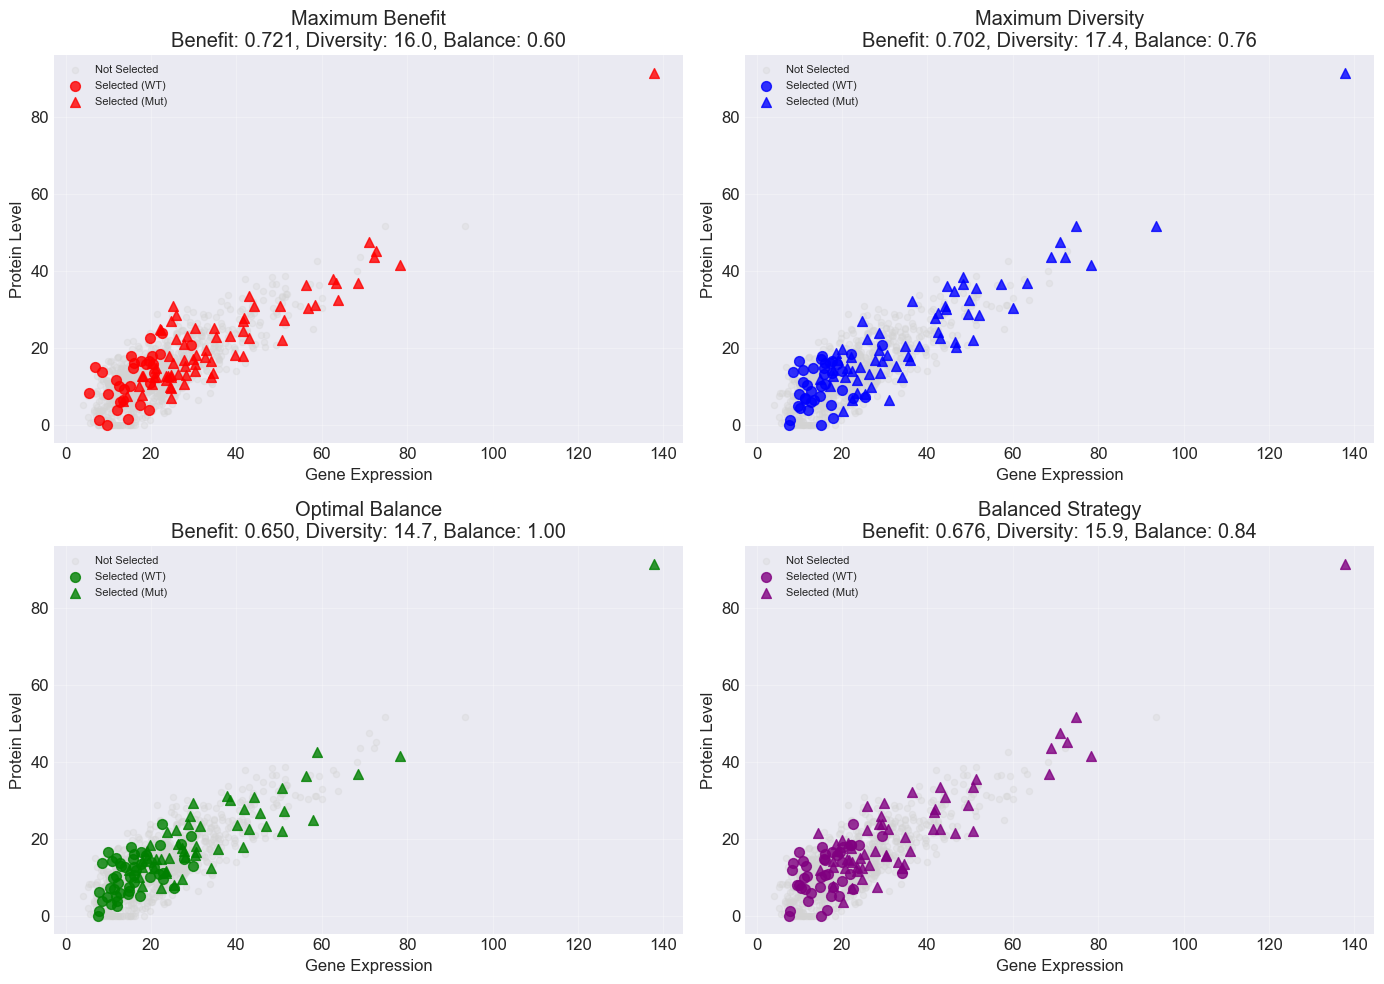


Detailed Strategy Comparison:

         Strategy Avg Response Prob Gene Expr SD Protein SD Mutation % Cell Count Dist
  Maximum Benefit             0.721         19.6       12.4      70.0%  L:1, M:5, H:94
Maximum Diversity             0.702         21.1       13.8      62.0%  L:2, M:7, H:91
  Optimal Balance             0.650         18.0       11.5      50.0%  L:2, M:7, H:91
Balanced Strategy             0.676         19.2       12.7      58.0%  L:1, M:7, H:92


In [16]:
if result_biomarker.pareto_front:
    # Find key solutions
    pareto_objs = np.array(result_biomarker.pareto_front)
    
    # Rescale objectives
    benefit_values = pareto_objs[:, 0] / 10
    diversity_values = pareto_objs[:, 1] * 10
    balance_values = pareto_objs[:, 2]
    info_values = pareto_objs[:, 3]
    
    # Find specific strategies
    max_benefit_idx = np.argmax(benefit_values)
    max_diversity_idx = np.argmax(diversity_values)
    max_balance_idx = np.argmax(balance_values)
    
    # Balanced solution
    normalized = (pareto_objs - pareto_objs.min(axis=0)) / (pareto_objs.max(axis=0) - pareto_objs.min(axis=0) + 1e-10)
    distances = np.sqrt(((1 - normalized)**2).sum(axis=1))
    balanced_idx = np.argmin(distances)
    
    strategies = [
        (max_benefit_idx, "Maximum Benefit", 'red'),
        (max_diversity_idx, "Maximum Diversity", 'blue'),
        (max_balance_idx, "Optimal Balance", 'green'),
        (balanced_idx, "Balanced Strategy", 'purple')
    ]
    
    # Visualize the strategies
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    for ax, (idx, name, color) in zip(axes.flatten(), strategies):
        # Get selected patients
        selected_idx = result_biomarker.pareto_solutions[idx]['selected_indices'][0]
        selected = biomarker_patients.iloc[selected_idx]
        not_selected = biomarker_patients.drop(biomarker_patients.index[selected_idx])
        
        # Scatter plot of gene expression vs protein level
        ax.scatter(not_selected['gene_expression'], not_selected['protein_level'],
                  c='lightgray', alpha=0.3, s=20, label='Not Selected')
        
        # Color selected by mutation status
        for mut_status, marker in [(0, 'o'), (1, '^')]:
            mask = selected['mutation_status'] == mut_status
            ax.scatter(selected[mask]['gene_expression'], 
                      selected[mask]['protein_level'],
                      c=color, marker=marker, s=50, alpha=0.8,
                      label=f'Selected ({"WT" if mut_status == 0 else "Mut"})')
        
        ax.set_xlabel('Gene Expression')
        ax.set_ylabel('Protein Level')
        ax.set_title(f'{name}\nBenefit: {benefit_values[idx]:.3f}, '
                    f'Diversity: {diversity_values[idx]:.1f}, '
                    f'Balance: {balance_values[idx]:.2f}')
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Compare strategies in detail
    print("\nDetailed Strategy Comparison:\n")
    
    comparison_data = []
    for idx, name, _ in strategies:
        selected_idx = result_biomarker.pareto_solutions[idx]['selected_indices'][0]
        selected = biomarker_patients.iloc[selected_idx]
        
        comparison_data.append({
            'Strategy': name,
            'Avg Response Prob': f"{selected['response_probability'].mean():.3f}",
            'Gene Expr SD': f"{selected['gene_expression'].std():.1f}",
            'Protein SD': f"{selected['protein_level'].std():.1f}",
            'Mutation %': f"{selected['mutation_status'].mean()*100:.1f}%",
            'Cell Count Dist': f"L:{(selected['cell_count']=='Low').sum()}, "
                              f"M:{(selected['cell_count']=='Medium').sum()}, "
                              f"H:{(selected['cell_count']=='High').sum()}"
        })
    
    comparison_df = pd.DataFrame(comparison_data)
    print(comparison_df.to_string(index=False))

## Part 5: Adaptive Trial Design <a name="part6"></a>

### The Challenge

Modern clinical trials often use adaptive designs that allow modifications based on accumulating data. Let's design an adaptive dose-finding trial that:
- Starts with a broad range of doses
- Adapts to focus on the most promising dose range
- Balances exploration (learning) with exploitation (treating patients optimally)
- Stops early if a clearly optimal dose is identified

We'll simulate how the trial would adapt over time.

In [17]:
class AdaptiveDoseFindingTrial:
    """
    Simulator for an adaptive dose-finding clinical trial.
    """
    def __init__(self, candidate_doses, true_response_func, n_stages=3, patients_per_stage=30):
        self.candidate_doses = np.array(candidate_doses)
        self.true_response_func = true_response_func
        self.n_stages = n_stages
        self.patients_per_stage = patients_per_stage
        
        # Storage for trial data
        self.stage_data = []
        self.selected_doses_by_stage = []
        self.posterior_estimates = []
        
    def run_stage(self, stage_num, available_doses, n_doses_to_select):
        """
        Run one stage of the adaptive trial.
        """
        print(f"\n=== Stage {stage_num + 1} ===")
        
        if stage_num == 0:
            # First stage: Use D-optimal design
            print("Using D-optimal design for initial dose selection...")
            
            # Create design matrix
            X = create_dose_design_matrix(available_doses)
            ts_data = make_data(M=X)
            ts_data["FeatureMat"] = X
            
            # Run optimization
            control = train_sel_control(niterations=50, npop=100, progress=False)
            result = train_sel(
                data=ts_data,
                candidates=[list(range(len(available_doses)))],
                setsizes=[n_doses_to_select],
                settypes=["UOS"],
                stat=dopt,
                control=control,
                verbose=False
            )
            
            selected_indices = result.selected_indices[0]
            selected_doses = available_doses[selected_indices]
            
        else:
            # Adaptive stages: Use Thompson sampling with information gain
            print("Using adaptive selection based on accumulated data...")
            
            # Fit a model to existing data
            from sklearn.gaussian_process import GaussianProcessRegressor
            from sklearn.gaussian_process.kernels import RBF, WhiteKernel
            
            # Prepare data from previous stages
            all_doses = []
            all_responses = []
            for stage_data in self.stage_data:
                all_doses.extend(stage_data['doses'])
                all_responses.extend(stage_data['responses'])
            
            X_train = np.array(all_doses).reshape(-1, 1)
            y_train = np.array(all_responses)
            
            # Fit Gaussian Process
            kernel = RBF(length_scale=30) + WhiteKernel(noise_level=0.1)
            gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
            gp.fit(X_train, y_train)
            
            # Predict for all available doses
            X_test = available_doses.reshape(-1, 1)
            mean_pred, std_pred = gp.predict(X_test, return_std=True)
            
            # Calculate acquisition function (Upper Confidence Bound)
            ucb = mean_pred + 2 * std_pred
            
            # Select doses with highest UCB, but ensure some diversity
            # Sort by UCB but also consider spacing
            ucb_order = np.argsort(-ucb)  # Descending order
            
            selected_indices = []
            selected_doses = []
            
            for idx in ucb_order:
                dose = available_doses[idx]
                # Check if dose is not too close to already selected doses
                if not selected_doses or all(abs(dose - d) > 20 for d in selected_doses):
                    selected_indices.append(idx)
                    selected_doses.append(dose)
                    if len(selected_doses) >= n_doses_to_select:
                        break
            
            # If we don't have enough doses due to spacing constraint, add the best remaining
            while len(selected_doses) < n_doses_to_select:
                for idx in ucb_order:
                    if idx not in selected_indices:
                        selected_indices.append(idx)
                        selected_doses.append(available_doses[idx])
                        break
            
            selected_doses = np.array(selected_doses)
            
            # Store posterior estimates
            self.posterior_estimates.append({
                'doses': available_doses,
                'mean': mean_pred,
                'std': std_pred,
                'ucb': ucb
            })
        
        # Simulate patient responses at selected doses
        print(f"Selected doses: {sorted(selected_doses)}")
        
        doses_used = []
        responses = []
        
        patients_per_dose = self.patients_per_stage // len(selected_doses)
        
        for dose in selected_doses:
            # Simulate patient responses
            true_effect, _ = self.true_response_func(dose)
            patient_responses = np.random.normal(true_effect, 10, patients_per_dose)
            
            doses_used.extend([dose] * patients_per_dose)
            responses.extend(patient_responses)
        
        # Store stage data
        stage_results = {
            'stage': stage_num + 1,
            'selected_doses': selected_doses,
            'doses': doses_used,
            'responses': responses,
            'mean_responses': {dose: np.mean([r for d, r in zip(doses_used, responses) if d == dose]) 
                             for dose in selected_doses}
        }
        
        self.stage_data.append(stage_results)
        self.selected_doses_by_stage.append(selected_doses)
        
        # Print stage results
        print("\nStage Results:")
        for dose in sorted(selected_doses):
            mean_resp = stage_results['mean_responses'][dose]
            print(f"  Dose {dose:.0f}mg: Mean response = {mean_resp:.1f}")
        
        return stage_results
    
    def run_trial(self):
        """
        Run the complete adaptive trial.
        """
        print("Starting Adaptive Dose-Finding Trial")
        print(f"Total stages: {self.n_stages}")
        print(f"Patients per stage: {self.patients_per_stage}")
        
        # Stage 1: Explore broadly
        available_doses = self.candidate_doses
        self.run_stage(0, available_doses, n_doses_to_select=6)
        
        # Stage 2: Focus on promising region
        # Reduce dose range based on stage 1 results
        stage1_results = self.stage_data[0]['mean_responses']
        best_doses = sorted(stage1_results.keys(), 
                           key=lambda d: stage1_results[d], reverse=True)[:3]
        
        # Define new dose range around best doses
        min_dose = max(0, min(best_doses) - 40)
        max_dose = min(200, max(best_doses) + 40)
        available_doses = self.candidate_doses[
            (self.candidate_doses >= min_dose) & (self.candidate_doses <= max_dose)
        ]
        
        self.run_stage(1, available_doses, n_doses_to_select=5)
        
        # Stage 3: Confirm optimal dose
        # Further narrow the range
        all_results = {}
        for stage_data in self.stage_data:
            all_results.update(stage_data['mean_responses'])
        
        best_doses = sorted(all_results.keys(), 
                           key=lambda d: all_results[d], reverse=True)[:2]
        
        min_dose = max(0, min(best_doses) - 20)
        max_dose = min(200, max(best_doses) + 20)
        available_doses = self.candidate_doses[
            (self.candidate_doses >= min_dose) & (self.candidate_doses <= max_dose)
        ]
        
        self.run_stage(2, available_doses, n_doses_to_select=4)
        
        return self.get_final_recommendation()
    
    def get_final_recommendation(self):
        """
        Analyze all data and make final dose recommendation.
        """
        # Combine all data
        all_doses = []
        all_responses = []
        
        for stage_data in self.stage_data:
            all_doses.extend(stage_data['doses'])
            all_responses.extend(stage_data['responses'])
        
        # Fit final model
        from sklearn.gaussian_process import GaussianProcessRegressor
        from sklearn.gaussian_process.kernels import RBF, WhiteKernel
        
        X = np.array(all_doses).reshape(-1, 1)
        y = np.array(all_responses)
        
        kernel = RBF(length_scale=30) + WhiteKernel(noise_level=0.1)
        gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
        gp.fit(X, y)
        
        # Predict for fine grid
        dose_grid = np.linspace(0, 200, 200)
        mean_pred, std_pred = gp.predict(dose_grid.reshape(-1, 1), return_std=True)
        
        # Find optimal dose
        optimal_idx = np.argmax(mean_pred)
        optimal_dose = dose_grid[optimal_idx]
        optimal_effect = mean_pred[optimal_idx]
        
        return {
            'optimal_dose': optimal_dose,
            'predicted_effect': optimal_effect,
            'dose_grid': dose_grid,
            'predictions': mean_pred,
            'uncertainties': std_pred,
            'gp_model': gp
        }

# Run the adaptive trial
adaptive_trial = AdaptiveDoseFindingTrial(
    candidate_doses=np.arange(0, 201, 10),
    true_response_func=true_dose_response,
    n_stages=3,
    patients_per_stage=30
)

final_recommendation = adaptive_trial.run_trial()

Starting Adaptive Dose-Finding Trial
Total stages: 3
Patients per stage: 30

=== Stage 1 ===
Using D-optimal design for initial dose selection...
Selected doses: [30, 90, 140, 180, 190, 200]

Stage Results:
  Dose 30mg: Mean response = 40.3
  Dose 90mg: Mean response = 64.0
  Dose 140mg: Mean response = 72.1
  Dose 180mg: Mean response = 82.4
  Dose 190mg: Mean response = 79.5
  Dose 200mg: Mean response = 74.6

=== Stage 2 ===
Using adaptive selection based on accumulated data...
Selected doses: [140, 150, 160, 170, 180]

Stage Results:
  Dose 140mg: Mean response = 75.4
  Dose 150mg: Mean response = 73.8
  Dose 160mg: Mean response = 83.8
  Dose 170mg: Mean response = 76.0
  Dose 180mg: Mean response = 74.6

=== Stage 3 ===
Using adaptive selection based on accumulated data...
Selected doses: [150, 160, 170, 190]

Stage Results:
  Dose 150mg: Mean response = 74.2
  Dose 160mg: Mean response = 76.8
  Dose 170mg: Mean response = 80.8
  Dose 190mg: Mean response = 82.4


### Visualizing the Adaptive Trial Progress

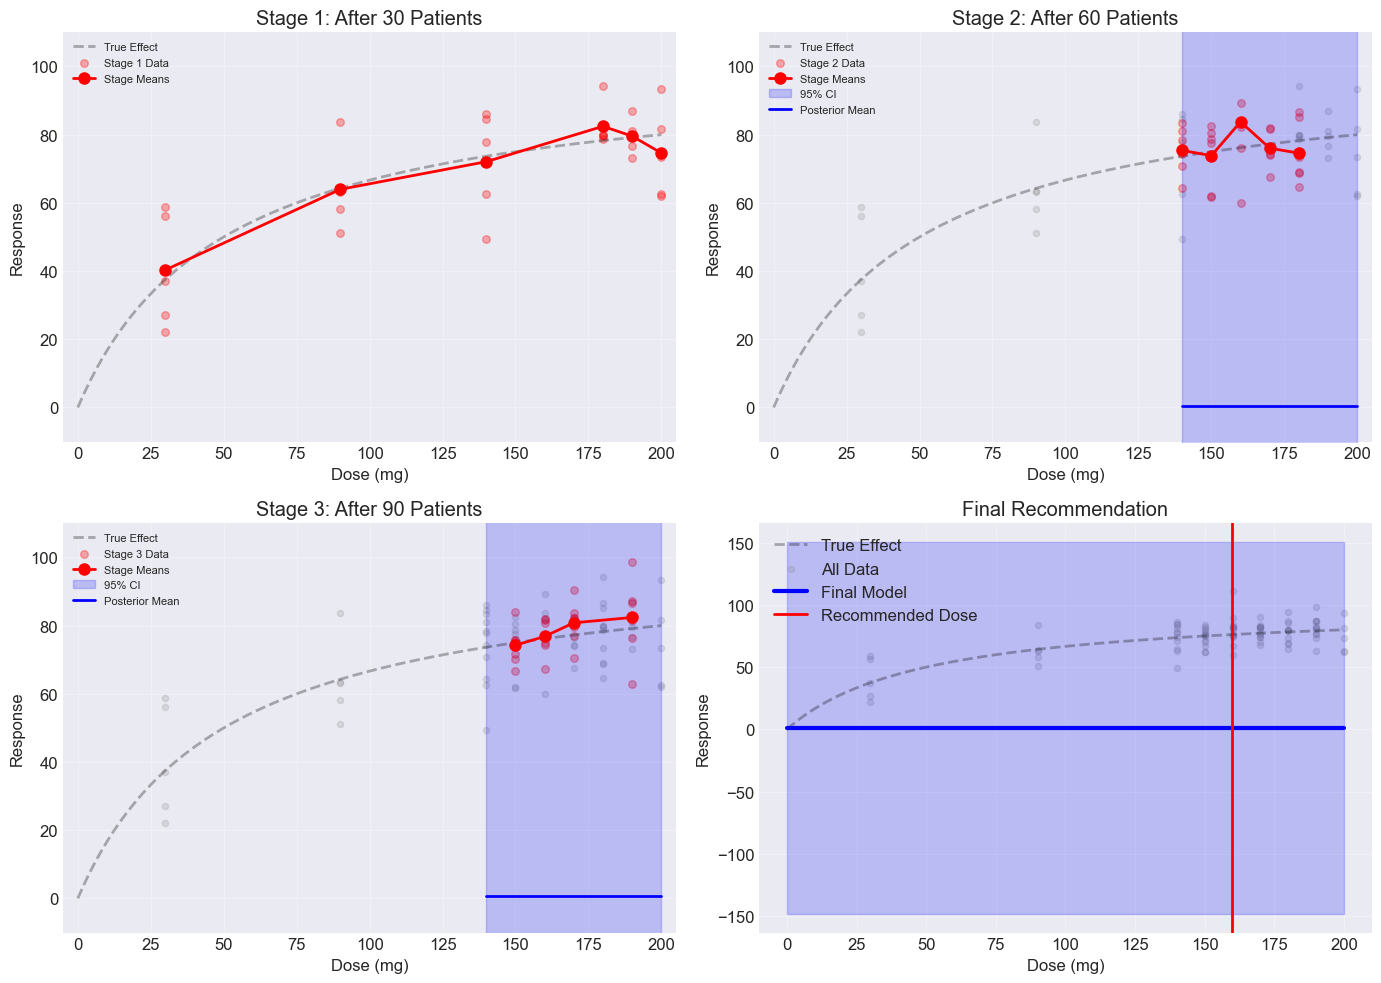


Final Recommendation:
Optimal Dose: 159.8 mg
Predicted Effect: 1.2

Total patients used: 88
Unique doses tested: 9


In [18]:
# Visualize how the trial adapted over stages
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# True dose-response curve (unknown to trial)
true_doses = np.linspace(0, 200, 200)
true_effects = [true_dose_response(d)[0] for d in true_doses]

# Stage-by-stage visualization
for stage in range(3):
    ax = axes[stage // 2, stage % 2]
    
    # Plot true curve
    ax.plot(true_doses, true_effects, 'k--', alpha=0.3, linewidth=2, label='True Effect')
    
    # Plot data collected up to this stage
    all_doses = []
    all_responses = []
    
    for s in range(stage + 1):
        stage_data = adaptive_trial.stage_data[s]
        doses = stage_data['doses']
        responses = stage_data['responses']
        
        # Plot individual observations
        if s == stage:  # Current stage in different color
            ax.scatter(doses, responses, alpha=0.3, s=30, color='red', label=f'Stage {s+1} Data')
        else:
            ax.scatter(doses, responses, alpha=0.2, s=20, color='gray')
        
        all_doses.extend(doses)
        all_responses.extend(responses)
    
    # Plot stage means
    stage_means = adaptive_trial.stage_data[stage]['mean_responses']
    doses_sorted = sorted(stage_means.keys())
    means_sorted = [stage_means[d] for d in doses_sorted]
    ax.plot(doses_sorted, means_sorted, 'ro-', markersize=8, linewidth=2, label='Stage Means')
    
    # If not the first stage, show the posterior
    if stage > 0 and stage <= len(adaptive_trial.posterior_estimates):
        post = adaptive_trial.posterior_estimates[stage - 1]
        ax.fill_between(post['doses'], 
                       post['mean'] - 2*post['std'],
                       post['mean'] + 2*post['std'],
                       alpha=0.2, color='blue', label='95% CI')
        ax.plot(post['doses'], post['mean'], 'b-', linewidth=2, label='Posterior Mean')
    
    ax.set_xlabel('Dose (mg)')
    ax.set_ylabel('Response')
    ax.set_title(f'Stage {stage + 1}: After {(stage + 1) * 30} Patients')
    ax.set_xlim(-5, 205)
    ax.set_ylim(-10, 110)
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

# Final recommendation
ax = axes[1, 1]
ax.plot(true_doses, true_effects, 'k--', alpha=0.3, linewidth=2, label='True Effect')

# All collected data
all_doses = []
all_responses = []
for stage_data in adaptive_trial.stage_data:
    all_doses.extend(stage_data['doses'])
    all_responses.extend(stage_data['responses'])

ax.scatter(all_doses, all_responses, alpha=0.2, s=20, color='gray', label='All Data')

# Final model prediction
ax.plot(final_recommendation['dose_grid'], 
       final_recommendation['predictions'], 
       'b-', linewidth=3, label='Final Model')
ax.fill_between(final_recommendation['dose_grid'],
               final_recommendation['predictions'] - 2*final_recommendation['uncertainties'],
               final_recommendation['predictions'] + 2*final_recommendation['uncertainties'],
               alpha=0.2, color='blue')

# Mark recommended dose
ax.axvline(x=final_recommendation['optimal_dose'], 
          color='red', linestyle='-', linewidth=2, label='Recommended Dose')

ax.set_xlabel('Dose (mg)')
ax.set_ylabel('Response')
ax.set_title('Final Recommendation')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nFinal Recommendation:")
print(f"Optimal Dose: {final_recommendation['optimal_dose']:.1f} mg")
print(f"Predicted Effect: {final_recommendation['predicted_effect']:.1f}")
print(f"\nTotal patients used: {len(all_doses)}")
print(f"Unique doses tested: {len(set(all_doses))}")

## Best Practices and Considerations <a name="best-practices"></a>

### Key Takeaways from Our Examples

Through our exploration of TrainSelPy for clinical trial design, we've seen several important principles:

#### 1. **Information is Precious in Clinical Trials**
- D-optimal designs can provide 10-20% more statistical information than random selection
- This translates to needing fewer patients for the same statistical power
- Or achieving better precision with the same number of patients

#### 2. **Multi-Objective Optimization Reflects Real-World Complexity**
- Clinical trials rarely have a single goal
- Trade-offs between efficacy, safety, cost, and logistics are inevitable
- Pareto fronts help visualize and choose among these trade-offs

#### 3. **Adaptive Designs Can Be More Ethical and Efficient**
- Learning from accumulating data allows better decisions
- Fewer patients exposed to ineffective doses
- Faster convergence to optimal treatments

#### 4. **Biomarker-Based Selection Requires Balance**
- Pure enrichment (selecting only likely responders) may miss important subgroups
- Diversity ensures learning about treatment effects across populations
- Information content should guide selection, not just expected outcomes

### Practical Implementation Considerations

In [19]:
# Example: Power calculation comparison
def calculate_sample_size_savings(information_gain_percent, baseline_n=100, power=0.8, alpha=0.05):
    """
    Calculate sample size savings from improved design efficiency.
    """
    # Information gain translates to variance reduction
    variance_reduction = 1 - (1 / (1 + information_gain_percent/100))
    
    # Sample size is inversely proportional to information
    optimized_n = baseline_n * (1 - variance_reduction)
    
    savings = baseline_n - optimized_n
    cost_savings = savings * 50000  # Assume $50k per patient
    
    return {
        'baseline_n': baseline_n,
        'optimized_n': int(optimized_n),
        'patients_saved': int(savings),
        'cost_savings': cost_savings,
        'percent_reduction': (savings / baseline_n) * 100
    }

# Calculate savings for different scenarios
scenarios = [
    ("Phase II Dose-Finding", 15, 80),
    ("Phase III Efficacy", 10, 300),
    ("Biomarker Stratified", 20, 200)
]

print("Potential Sample Size Savings from Optimal Design:\n")
for name, info_gain, baseline_n in scenarios:
    savings = calculate_sample_size_savings(info_gain, baseline_n)
    print(f"{name}:")
    print(f"  Information gain: {info_gain}%")
    print(f"  Baseline sample size: {savings['baseline_n']}")
    print(f"  Optimized sample size: {savings['optimized_n']}")
    print(f"  Patients saved: {savings['patients_saved']} ({savings['percent_reduction']:.1f}%)")
    print(f"  Cost savings: ${savings['cost_savings']:,.0f}\n")

Potential Sample Size Savings from Optimal Design:

Phase II Dose-Finding:
  Information gain: 15%
  Baseline sample size: 80
  Optimized sample size: 69
  Patients saved: 10 (13.0%)
  Cost savings: $521,739

Phase III Efficacy:
  Information gain: 10%
  Baseline sample size: 300
  Optimized sample size: 272
  Patients saved: 27 (9.1%)
  Cost savings: $1,363,636

Biomarker Stratified:
  Information gain: 20%
  Baseline sample size: 200
  Optimized sample size: 166
  Patients saved: 33 (16.7%)
  Cost savings: $1,666,667



### Regulatory and Ethical Considerations

When implementing optimal designs in clinical trials:

1. **Pre-specification is Critical**
   - Optimization criteria must be defined before the trial starts
   - Adaptive rules must be fully specified in the protocol
   - Simulations should demonstrate operating characteristics

2. **Transparency in Selection**
   - Document why certain patients/sites/doses were selected
   - Ensure selection doesn't introduce bias
   - Consider stratification to ensure representation

3. **Ethical Balance**
   - Optimization shouldn't compromise patient safety
   - Consider adding constraints for ethical requirements
   - Ensure equitable access across populations

4. **Robustness to Assumptions**
   - Test designs under various scenarios
   - Include sensitivity analyses
   - Have contingency plans for unexpected results

## Conclusion and Further Resources <a name="conclusion"></a>

### What We've Learned

This tutorial has demonstrated how TrainSelPy can revolutionize clinical trial design by:

1. **Optimizing Patient Selection** - Choosing participants that maximize information about treatment effects
2. **Balancing Multiple Objectives** - Finding optimal trade-offs between competing goals
3. **Designing Efficient Dose-Finding Studies** - Selecting doses that best characterize the dose-response relationship
4. **Enabling Precision Medicine** - Selecting patients based on biomarkers while maintaining diversity
5. **Supporting Adaptive Designs** - Allowing trials to learn and adapt as data accumulates

### The Power of Optimization in Clinical Research

By applying these optimization techniques, we can:
- **Reduce sample sizes** while maintaining statistical power
- **Decrease trial costs** through more efficient designs
- **Minimize patient exposure** to ineffective treatments
- **Accelerate drug development** by learning faster
- **Improve generalizability** through thoughtful selection

### Next Steps

To apply these methods in your own clinical trials:

1. **Start Simple** - Begin with single-objective optimization for straightforward problems
2. **Collaborate with Statisticians** - Ensure proper implementation and regulatory compliance
3. **Simulate Extensively** - Test your designs under various scenarios before implementation
4. **Document Thoroughly** - Keep detailed records of optimization criteria and decisions
5. **Share Knowledge** - Publish your experiences to advance the field

### Further Resources

- **TrainSelPy Documentation**: Full API reference and additional examples
- **FDA Guidance on Adaptive Designs**: Regulatory perspective on adaptive trials
- **Optimal Design Literature**: Academic papers on D-optimality and related criteria
- **Clinical Trial Simulation**: Tools and methods for simulating trial designs

### Final Thoughts

The future of clinical trials lies in smarter, more efficient designs. By leveraging optimization algorithms like those in TrainSelPy, we can conduct trials that are simultaneously more informative, more ethical, and more cost-effective. Every patient who participates in a clinical trial is making a contribution to medical knowledge - it's our responsibility to ensure that contribution is maximized.

Remember: **Better designs lead to better decisions, which ultimately lead to better treatments for patients.**

Thank you for joining me on this journey through optimal clinical trial design!